In [7]:
# Core
import re, os, numpy as np, pandas as pd
from typing import Callable, Dict, List, Tuple

# Modeling
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

# Plotting (matplotlib only)
import matplotlib.pyplot as plt

# Utils
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42

# Where to optionally save figures (set SAVE_FIGS=True to write PNGs)
FIG_DIR = "figs_loso_subjects"
SAVE_FIGS = False
os.makedirs(FIG_DIR, exist_ok=True)


In [ ]:
CSV = "DOVE_Hypoxia_Data_Manually_Synced.csv"   
TARGET_COL = "Rad97-60/SpO2"                    

df = pd.read_csv(CSV)
df.columns = [c.strip() for c in df.columns]

# Keep the columns we need
use_cols = ["SubjectID", "r_value", "skintone", TARGET_COL]
df = df[use_cols].replace([np.inf, -np.inf], np.nan).dropna()

# Extract numeric subject index for grouping
df["SubjectNum"] = df["SubjectID"].str.extract(r"Subject(\d+)", expand=False).astype(int)

print("Rows:", len(df), "| Unique subjects:", df["SubjectNum"].nunique())
df.head(3)


Rows: 604 | Unique subjects: 11


SubjectID   r_value  skintone  Rad97-60/SpO2  SubjectNum
0  Subject1  0.858301     1.992             91           1
1  Subject1  0.831904     1.992             91           1
2  Subject1  0.922036     1.992             90           1

In [9]:
def loso_eval_per_subject(
    X: np.ndarray,
    y: np.ndarray,
    groups: np.ndarray,
    fit_predict_fn: Callable[[np.ndarray, np.ndarray, np.ndarray], np.ndarray],
):
    """
    Runs LOSO and returns:
      - metrics_df: one row per held-out subject with MAE, RMSE, r, and n_test
      - preds: list of dicts with {subject, y_true, y_pred} for plotting
    """
    logo = LeaveOneGroupOut()
    rows = []
    preds = []

    for tr, te in logo.split(X, y, groups):
        subj = int(groups[te][0])
        y_tr, y_te = y[tr], y[te]
        y_hat = fit_predict_fn(X[tr], y_tr, X[te])

        m_mae  = mean_absolute_error(y_te, y_hat)
        m_rmse = rmse(y_te, y_hat)
        r = np.corrcoef(y_te, y_hat)[0,1] if (np.std(y_te)>1e-9 and np.std(y_hat)>1e-9) else np.nan

        rows.append({"SubjectNum": subj, "MAE": m_mae, "RMSE": m_rmse, "r": r, "n_test": len(y_te)})
        preds.append({"SubjectNum": subj, "y_true": y_te, "y_pred": y_hat})

    metrics_df = pd.DataFrame(rows).sort_values("SubjectNum").reset_index(drop=True)
    return metrics_df, preds


def plot_per_subject_bars(metrics_df: pd.DataFrame, title_prefix: str):
    """Bar charts of MAE and RMSE per subject (two separate figures)."""
    # MAE
    plt.figure(figsize=(10, 4))
    plt.bar(metrics_df["SubjectNum"].astype(str), metrics_df["MAE"])
    plt.xlabel("Subject")
    plt.ylabel("MAE (SpO2 %)")
    plt.title(f"{title_prefix} — Per-Subject MAE")
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"{title_prefix}_per_subject_MAE.png"), dpi=150)
    plt.show()

    # RMSE
    plt.figure(figsize=(10, 4))
    plt.bar(metrics_df["SubjectNum"].astype(str), metrics_df["RMSE"])
    plt.xlabel("Subject")
    plt.ylabel("RMSE (SpO2 %)")
    plt.title(f"{title_prefix} — Per-Subject RMSE")
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(os.path.join(FIG_DIR, f"{title_prefix}_per_subject_RMSE.png"), dpi=150)
    plt.show()


def plot_per_subject_predictions(preds: List[Dict], title_prefix: str, scatter_also=True):
    """
    For each subject (left-out fold), plots:
      - Time-series overlay: Actual vs Predicted
      - Optionally, scatter Actual vs Predicted with y=x
    """
    for item in sorted(preds, key=lambda d: d["SubjectNum"]):
        s   = item["SubjectNum"]
        yt  = item["y_true"]
        yh  = item["y_pred"]

        # Time-series overlay (index order)
        plt.figure(figsize=(10, 4))
        plt.plot(yt, label="Actual", alpha=0.9)
        plt.plot(yh, label="Predicted", alpha=0.9)
        plt.xlabel("Sample index (held-out subject)")
        plt.ylabel("SpO2 (%)")
        plt.title(f"{title_prefix} — Subject {s}: Actual vs Predicted")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(os.path.join(FIG_DIR, f"{title_prefix}_subject_{s}_timeseries.png"), dpi=150)
        plt.show()

        if scatter_also:
            # Scatter (equal aspect)
            plt.figure(figsize=(5, 5))
            plt.scatter(yt, yh, alpha=0.7)
            lims = [min(yt.min(), yh.min()), max(yt.max(), yh.max())]
            plt.plot(lims, lims, linestyle="--")
            plt.xlim(lims); plt.ylim(lims)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.xlabel("Actual SpO2 (%)")
            plt.ylabel("Predicted SpO2 (%)")
            plt.title(f"{title_prefix} — Subject {s}: Scatter")
            plt.grid(True)
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(os.path.join(FIG_DIR, f"{title_prefix}_subject_{s}_scatter.png"), dpi=150)
            plt.show()


SubjectNum       MAE      RMSE         r  n_test
0            1  4.871405  5.930773  0.885513      37
1            2  4.046876  4.771560  0.959831      32
2            3  1.493667  1.926109  0.980265      74
3            4  3.416970  4.695104  0.960910      53
4            5  2.145840  2.610427  0.970294      49
5            6  1.737580  2.114517  0.979953      42
6            7  1.970944  2.432320  0.976343      59
7            8  1.452197  1.787408  0.983059      62
8            9  2.131128  2.454732  0.984614      70
9           11  4.199301  5.049692  0.972193      58
10          12  1.311894  1.943700  0.980290      68

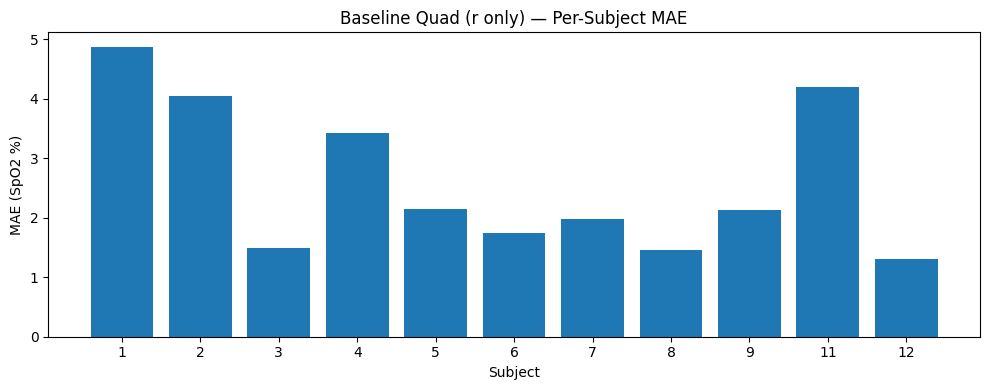

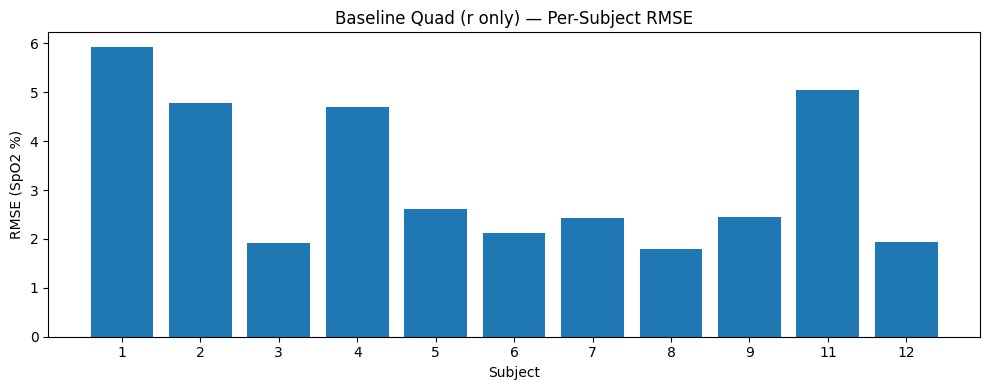

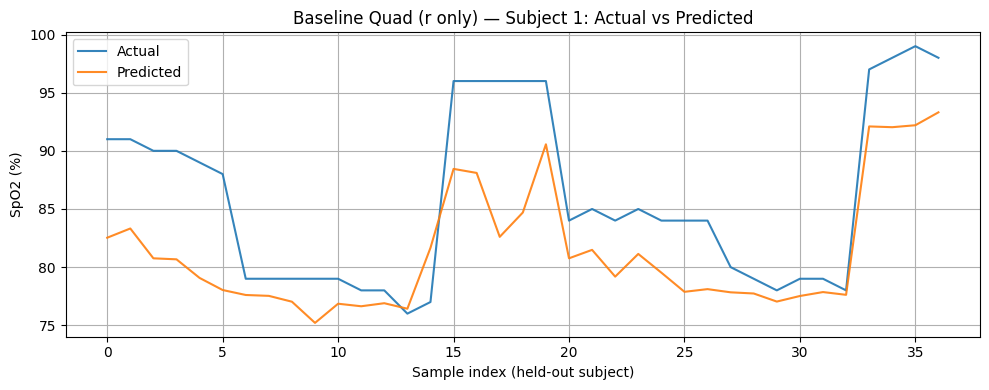

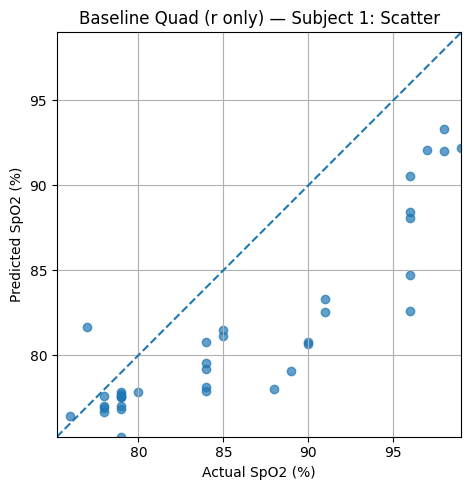

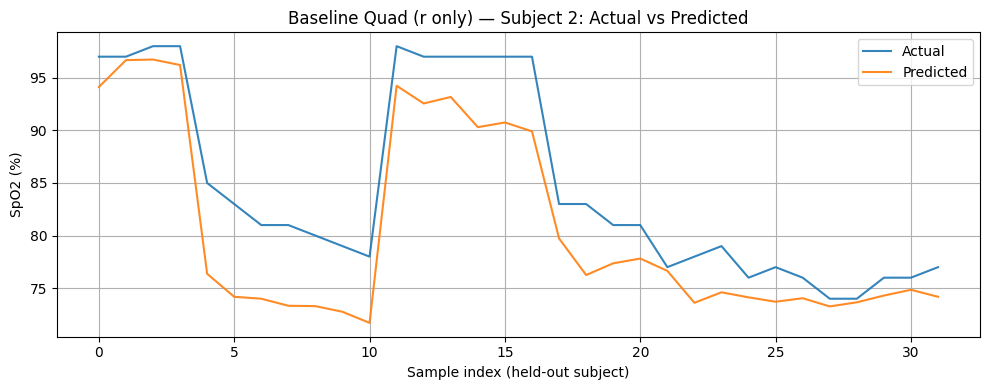

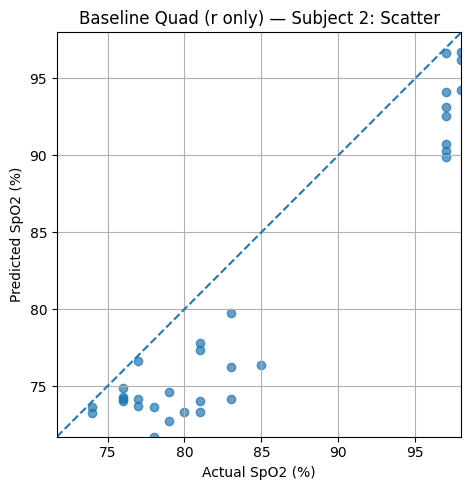

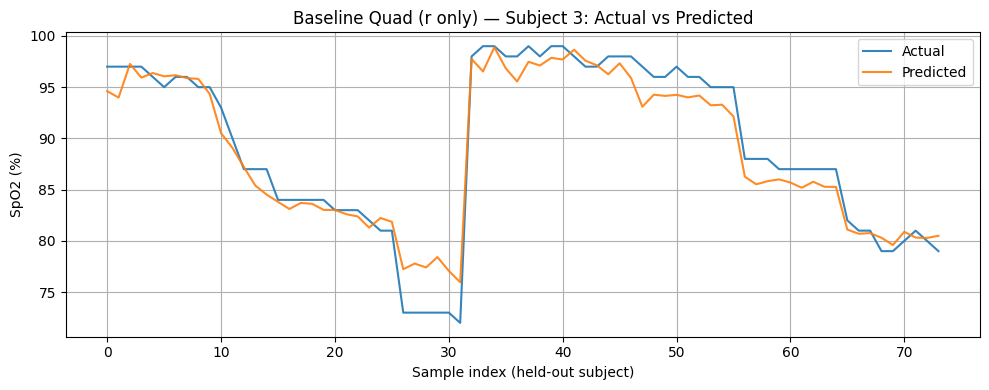

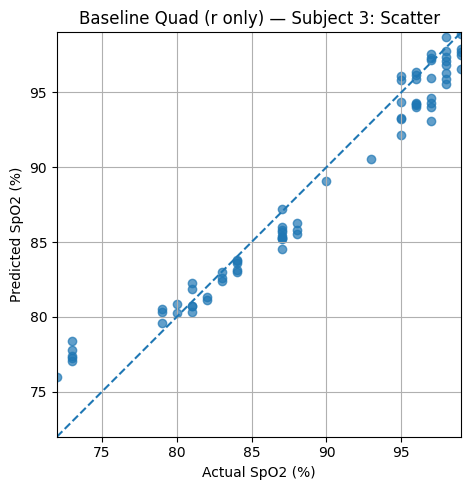

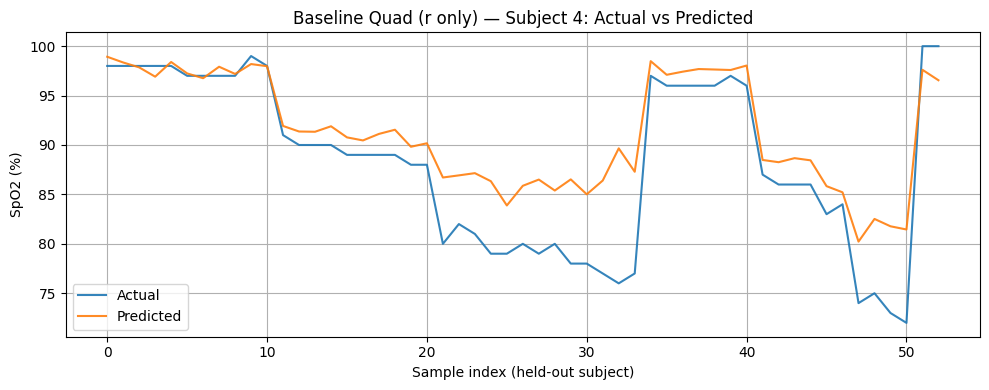

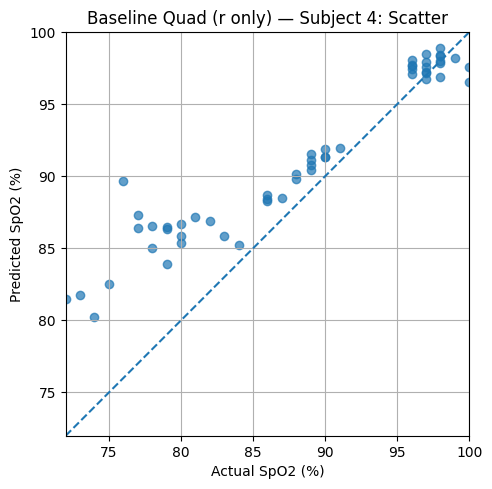

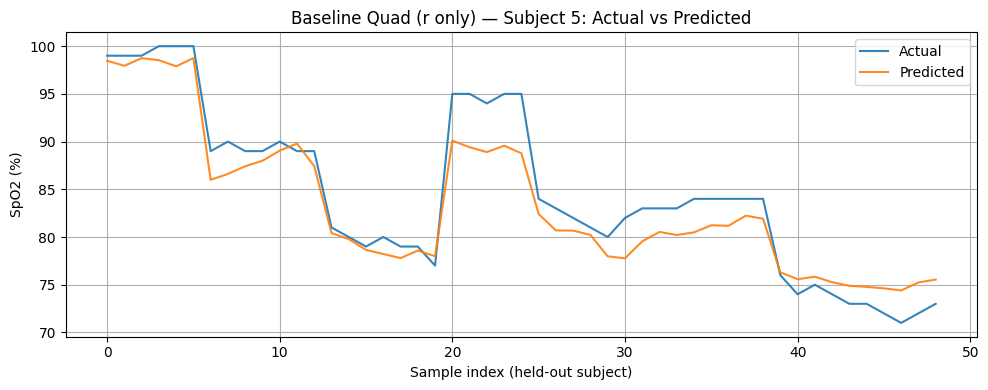

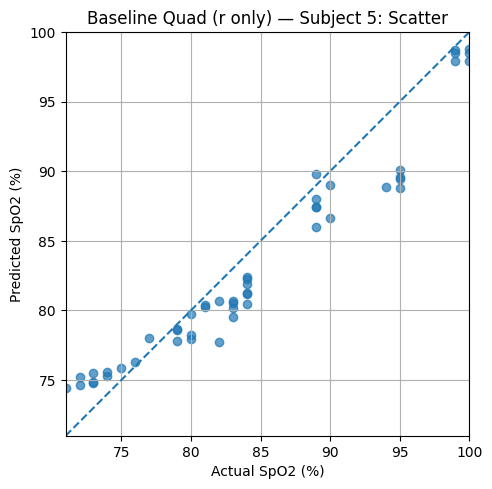

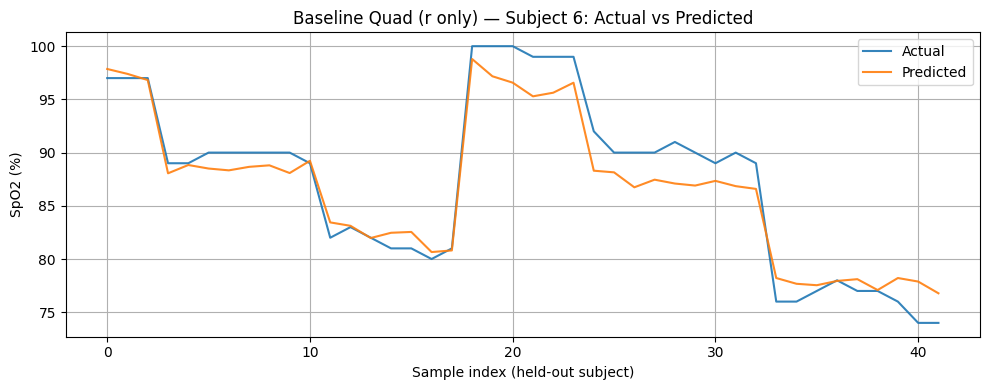

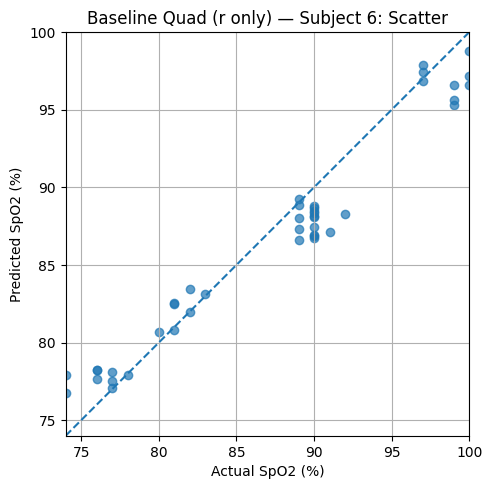

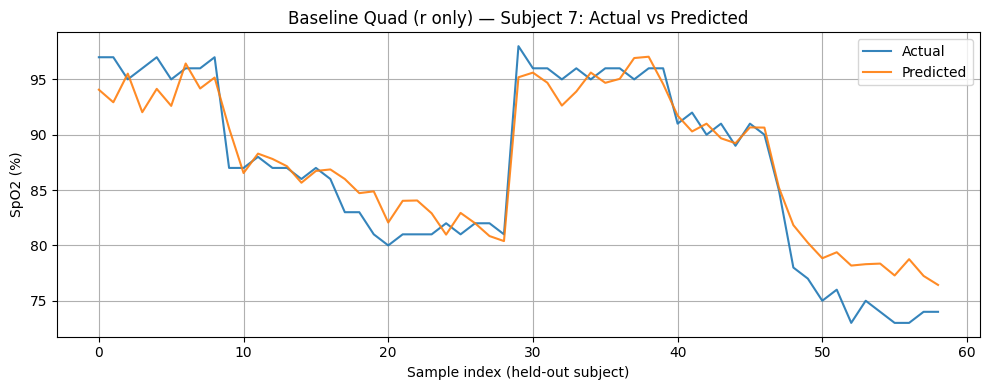

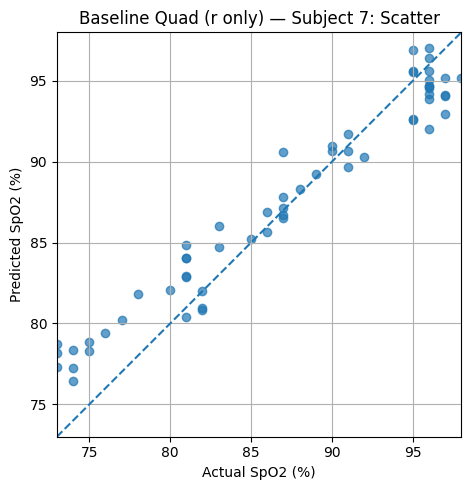

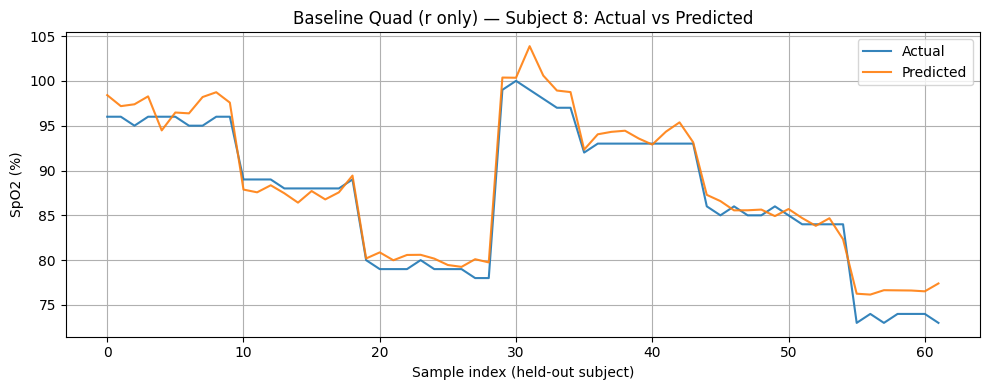

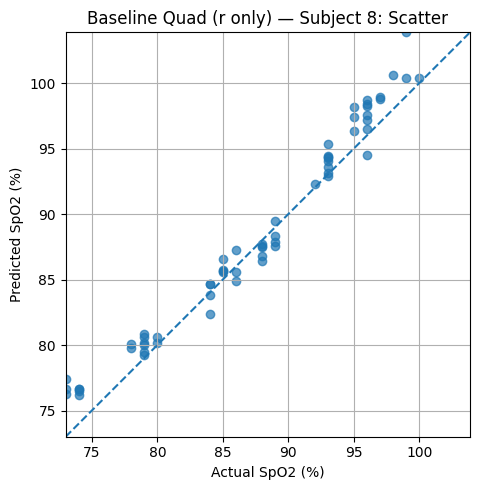

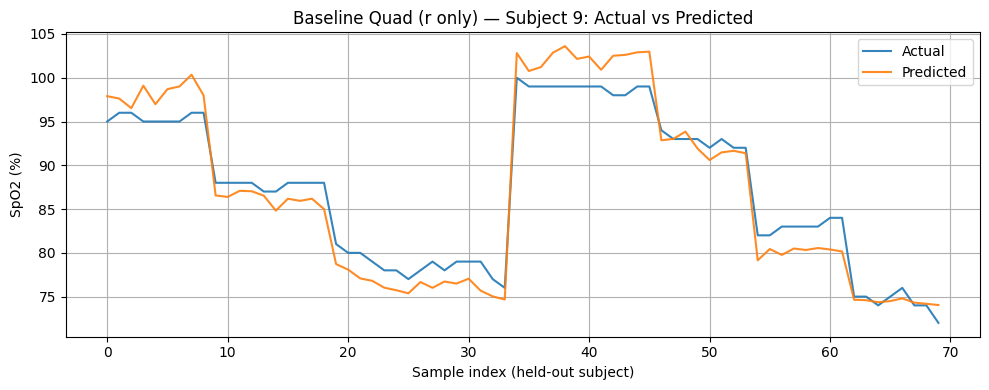

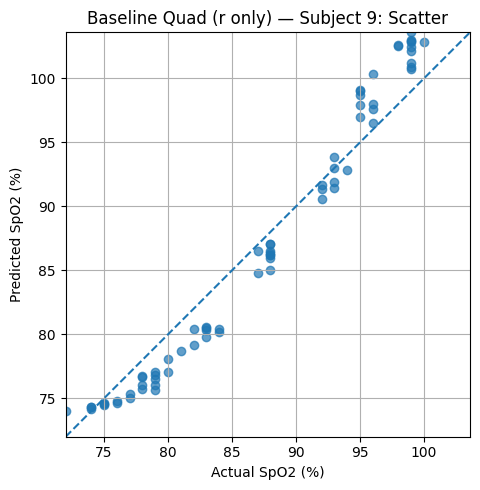

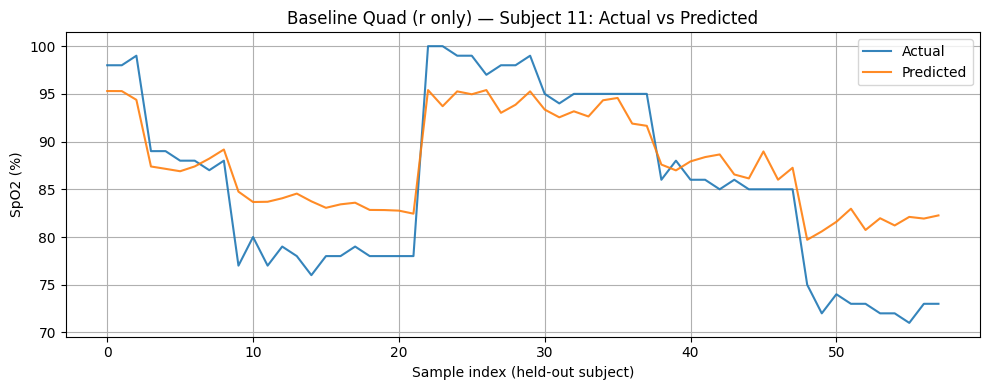

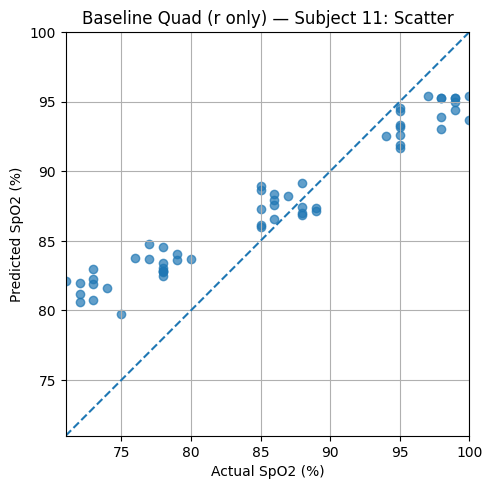

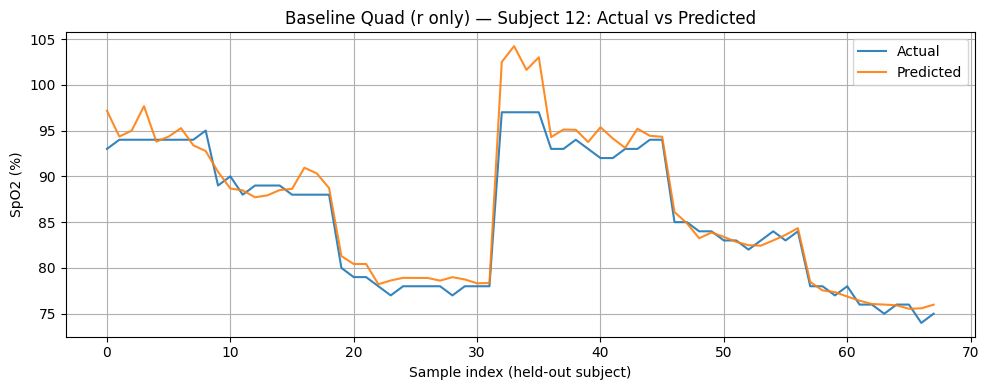

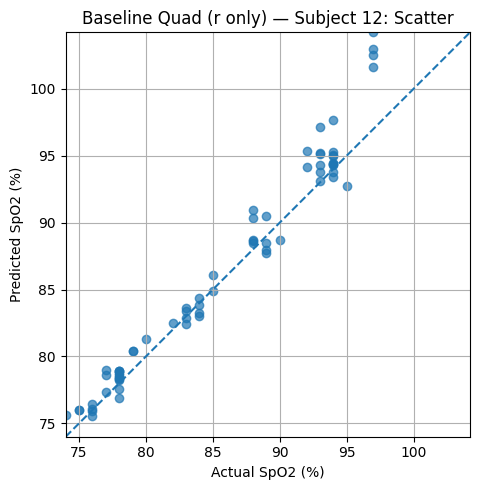

In [10]:
# Features/target/groups
y = df[TARGET_COL].values
groups = df["SubjectNum"].values

# Baseline uses r_value only
X_base = df[["r_value"]].values

def quad_baseline_fit_predict(Xtr, ytr, Xte):
    r_tr = Xtr[:, 0]
    r_te = Xte[:, 0]
    m = ~np.isnan(r_tr) & ~np.isnan(ytr) & ~np.isinf(r_tr) & ~np.isinf(ytr)
    a, b, c = np.polyfit(r_tr[m], ytr[m], deg=2)
    return a * r_te**2 + b * r_te + c

metrics_quad, preds_quad = loso_eval_per_subject(X_base, y, groups, quad_baseline_fit_predict)
display(metrics_quad)

plot_per_subject_bars(metrics_quad, title_prefix="Baseline Quad (r only)")
plot_per_subject_predictions(preds_quad, title_prefix="Baseline Quad (r only)", scatter_also=True)


SubjectNum       MAE      RMSE         r  n_test
0            1  5.184985  6.241199  0.857521      37
1            2  3.497999  4.304668  0.955507      32
2            3  1.888997  2.471158  0.955500      74
3            4  3.635440  4.837883  0.948545      53
4            5  2.990644  3.612938  0.935775      49
5            6  1.738054  2.135976  0.975044      42
6            7  1.961463  2.425505  0.966547      59
7            8  1.643624  2.019738  0.974762      62
8            9  1.832342  2.205579  0.972511      70
9           11  3.835709  4.771097  0.957895      58
10          12  1.841674  2.106973  0.979013      68

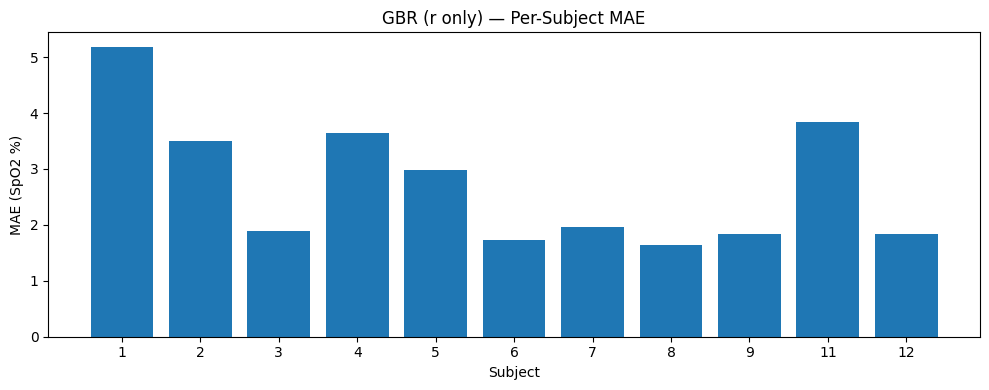

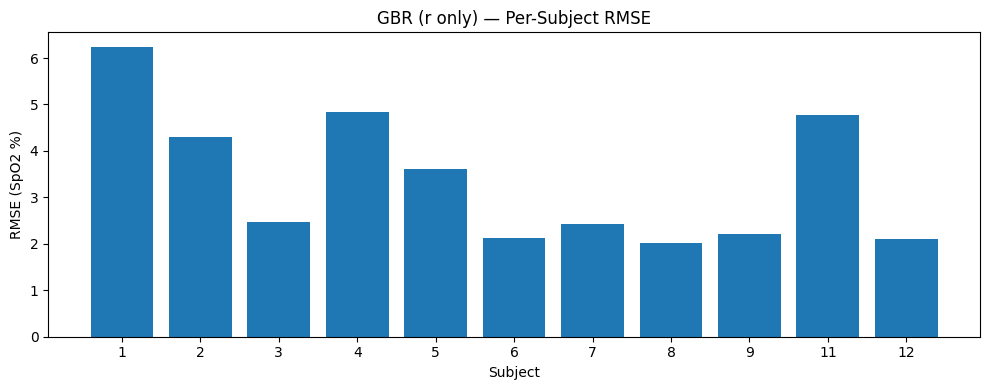

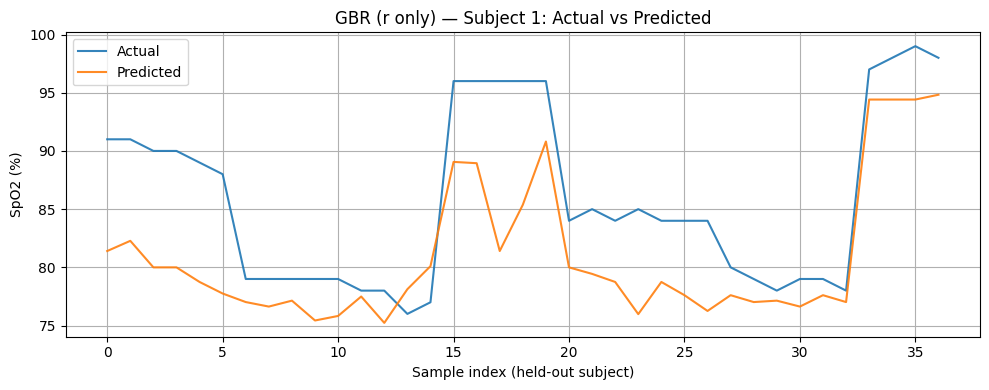

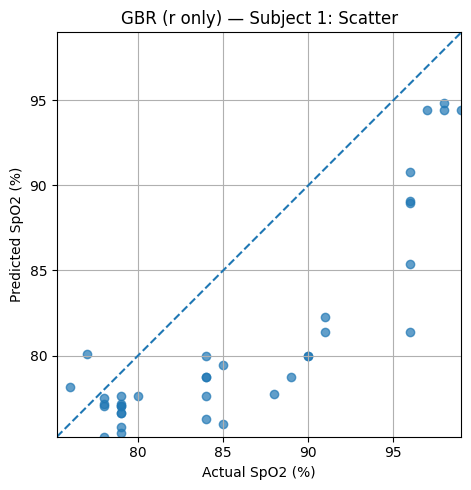

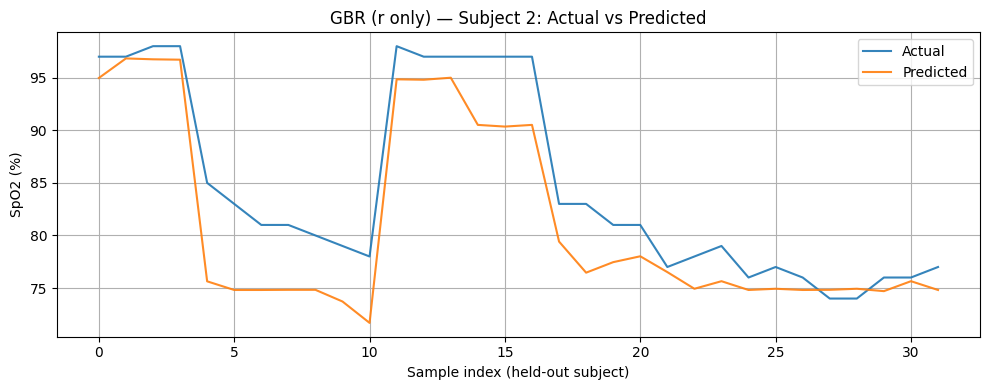

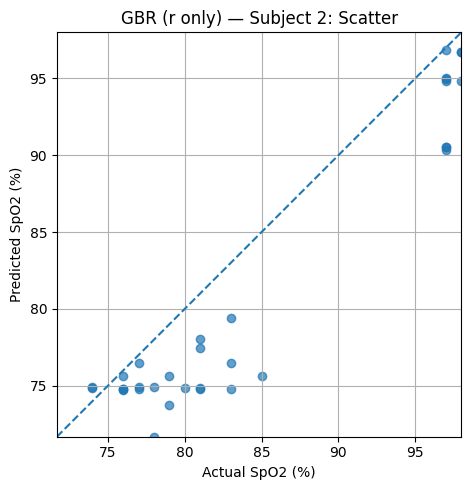

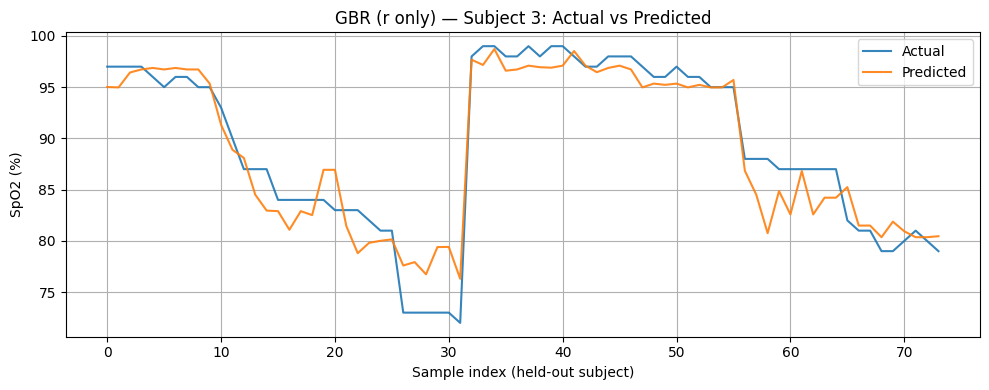

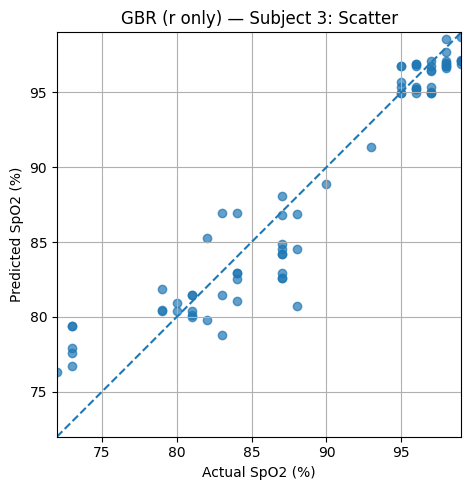

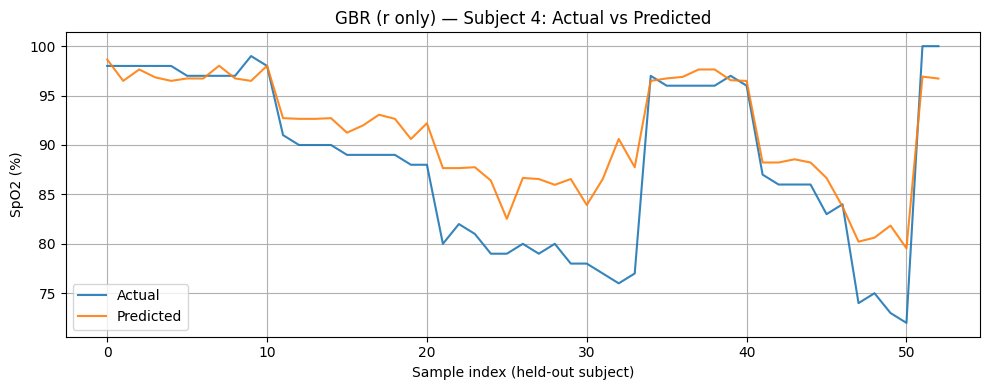

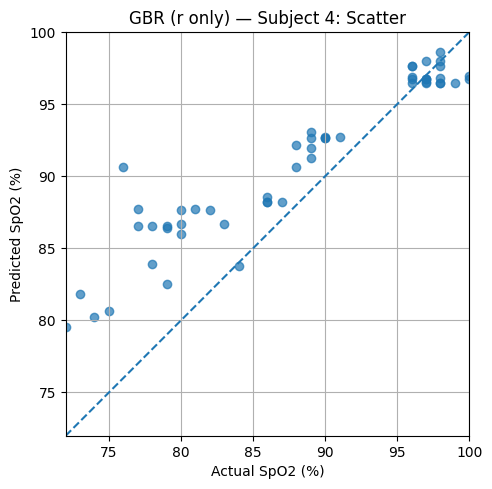

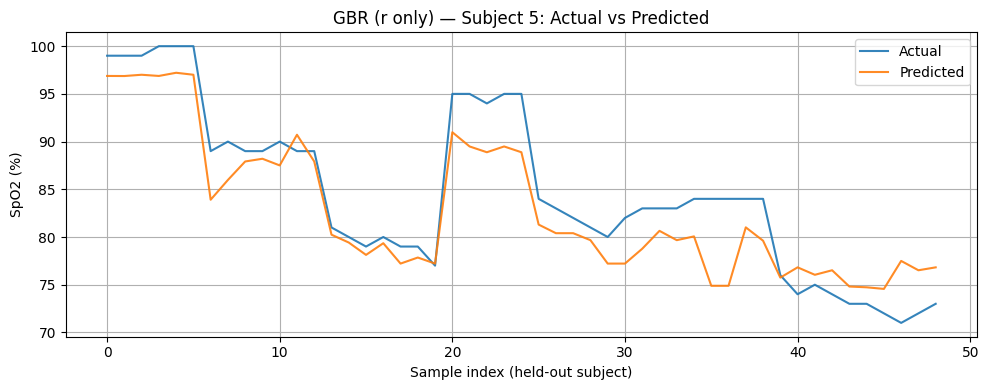

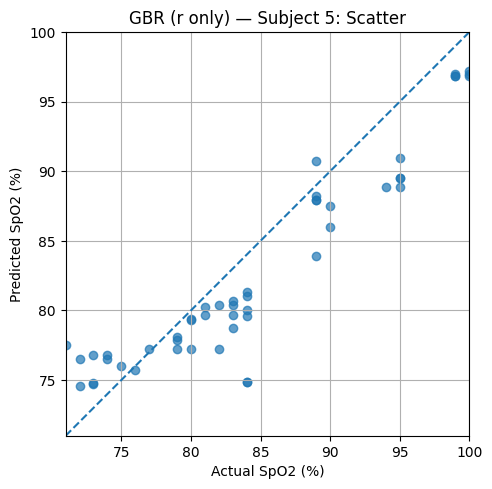

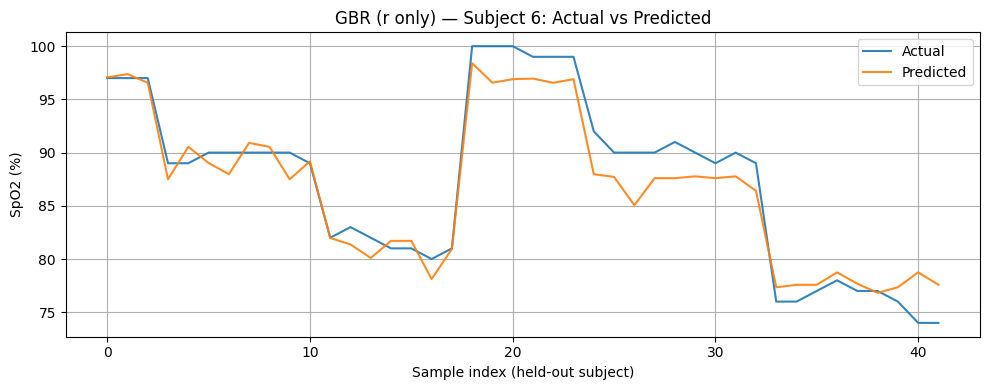

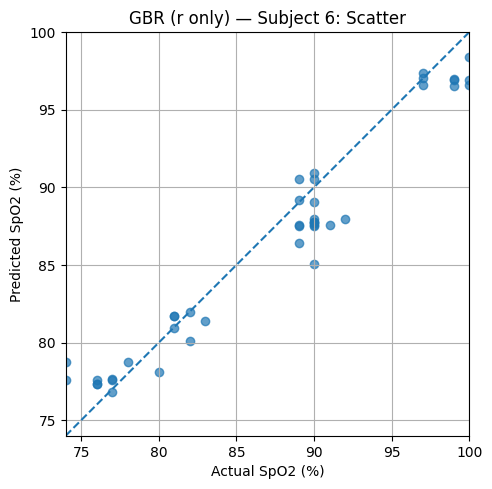

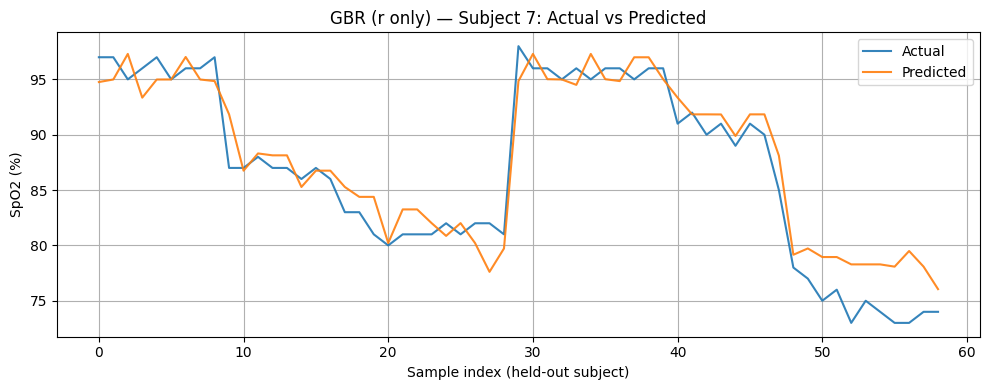

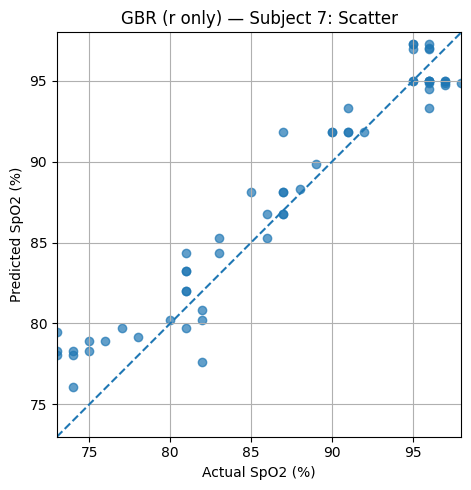

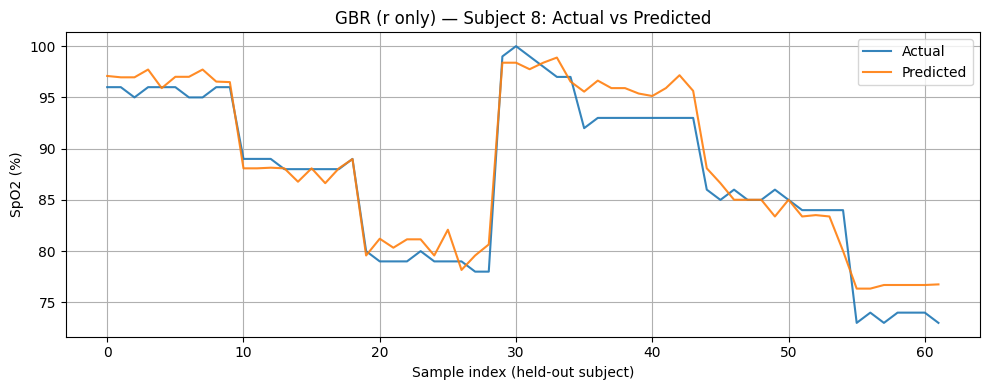

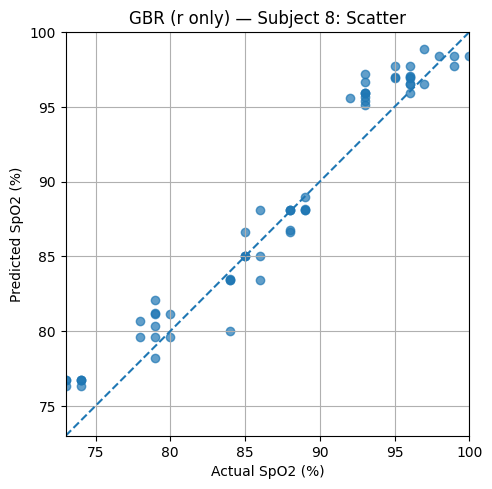

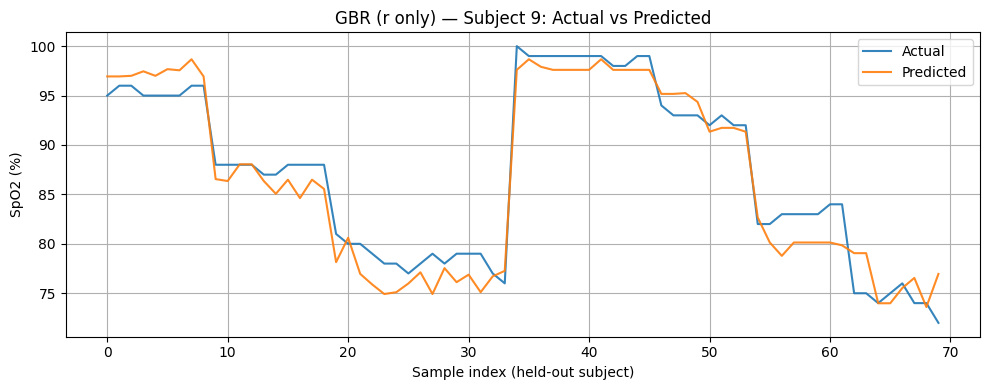

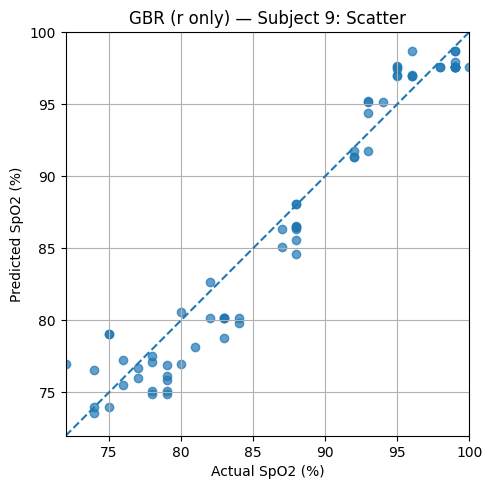

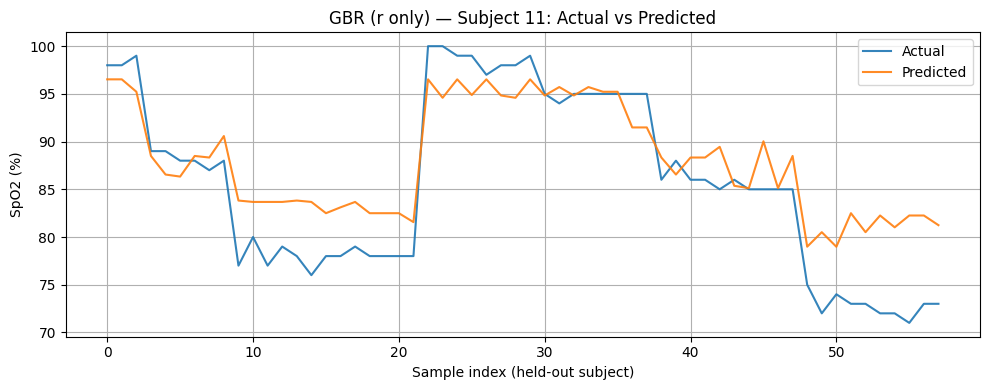

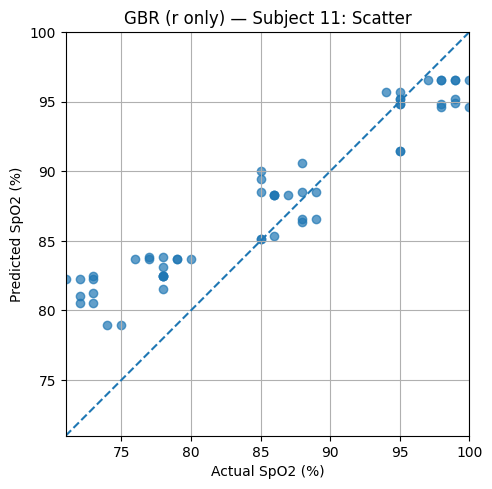

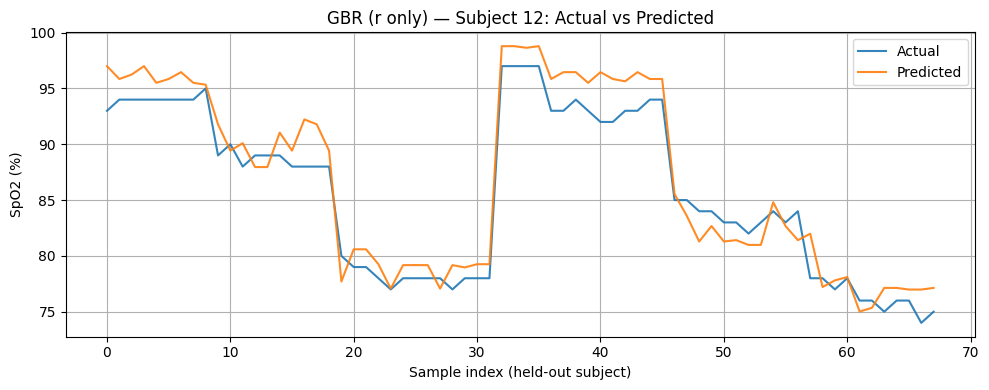

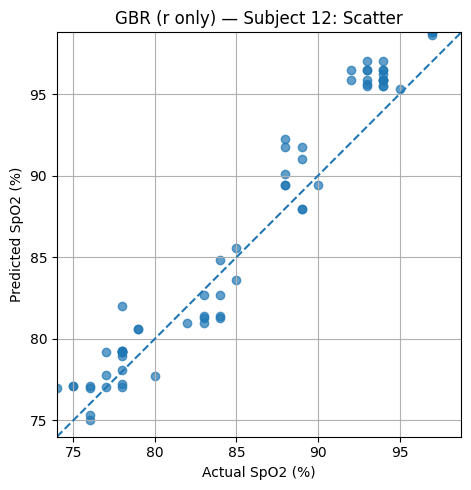

In [11]:
def gbr_fit_predict(Xtr, ytr, Xte):
    model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    model.fit(Xtr, ytr)
    return model.predict(Xte)

X_no_tone   = df[["r_value"]].values
metrics_gbr_no, preds_gbr_no = loso_eval_per_subject(X_no_tone, y, groups, gbr_fit_predict)
display(metrics_gbr_no)

plot_per_subject_bars(metrics_gbr_no, title_prefix="GBR (r only)")
plot_per_subject_predictions(preds_gbr_no, title_prefix="GBR (r only)", scatter_also=True)


SubjectNum       MAE      RMSE         r  n_test
0            1  5.716899  6.536851  0.887468      37
1            2  5.606958  6.329279  0.957845      32
2            3  3.322106  4.285459  0.962497      74
3            4  3.968467  5.224371  0.947719      53
4            5  3.111719  3.787063  0.952149      49
5            6  1.946160  2.274243  0.984579      42
6            7  2.159677  2.677573  0.971276      59
7            8  5.115610  5.335667  0.981195      62
8            9  2.122307  2.776770  0.979716      70
9           11  4.816176  6.042740  0.967226      58
10          12  2.795426  3.164106  0.978619      68

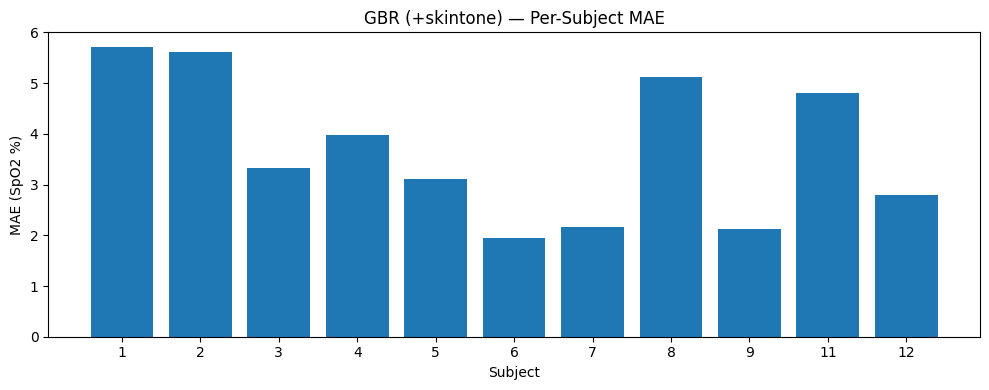

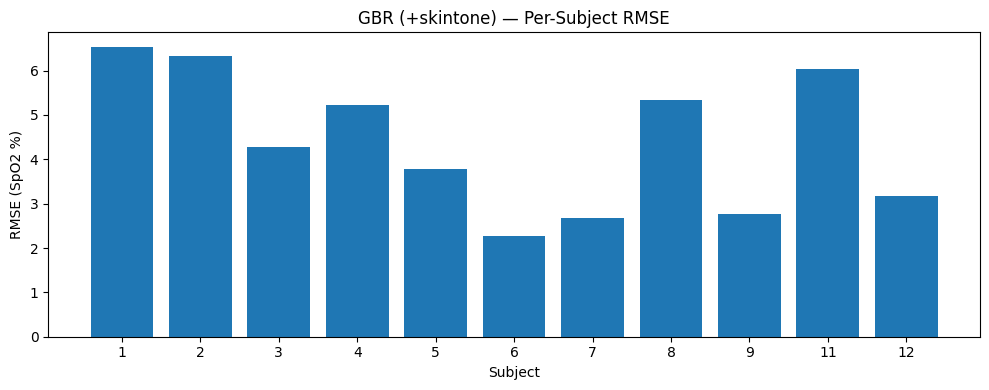

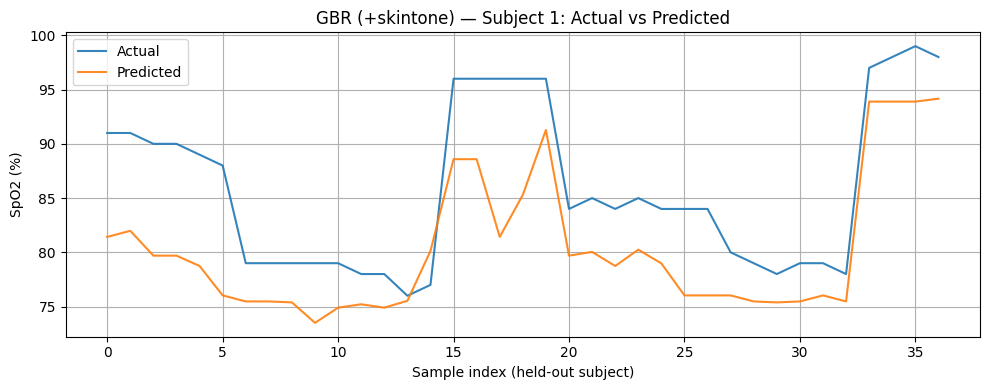

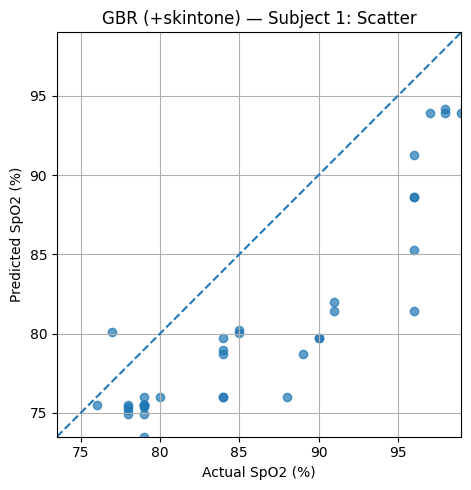

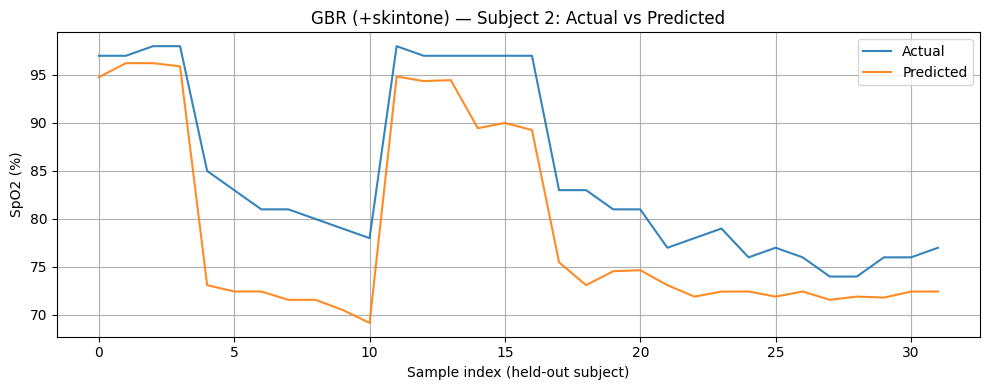

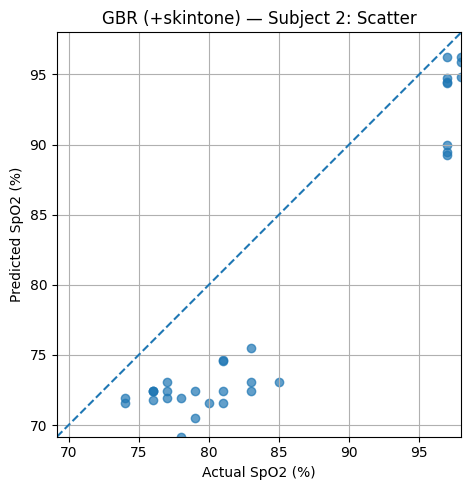

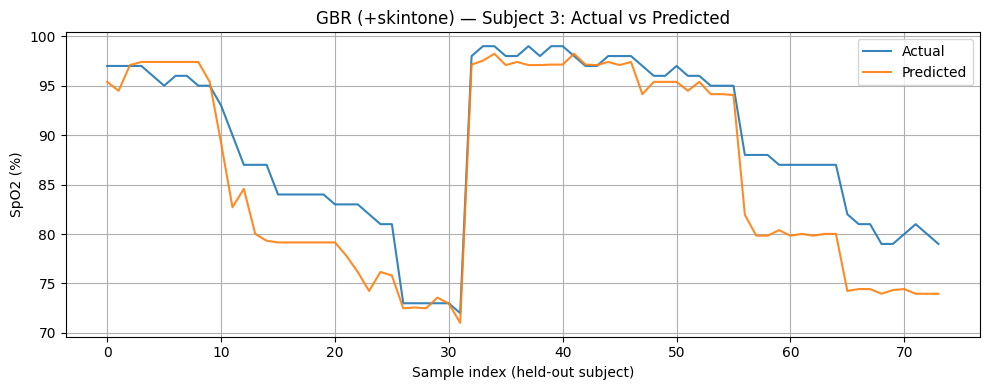

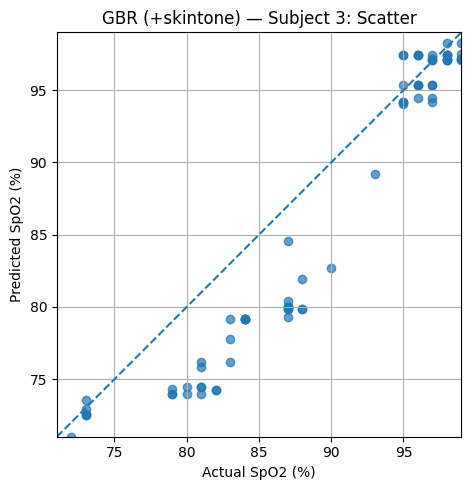

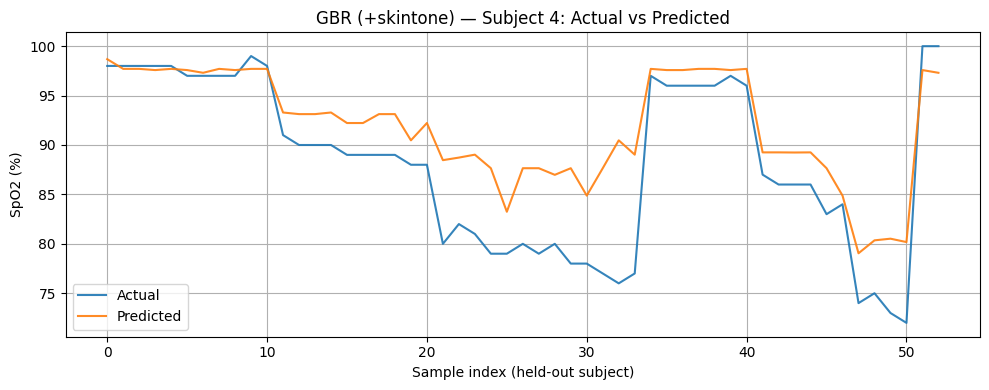

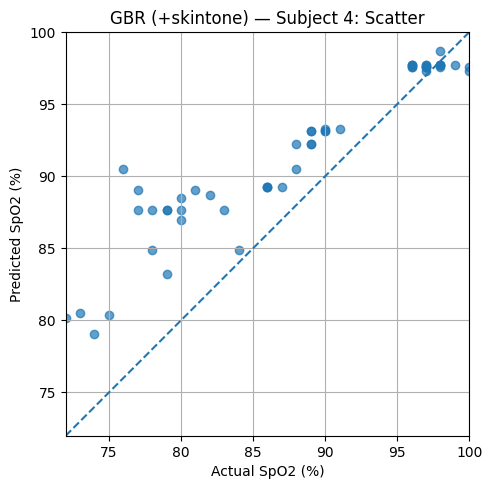

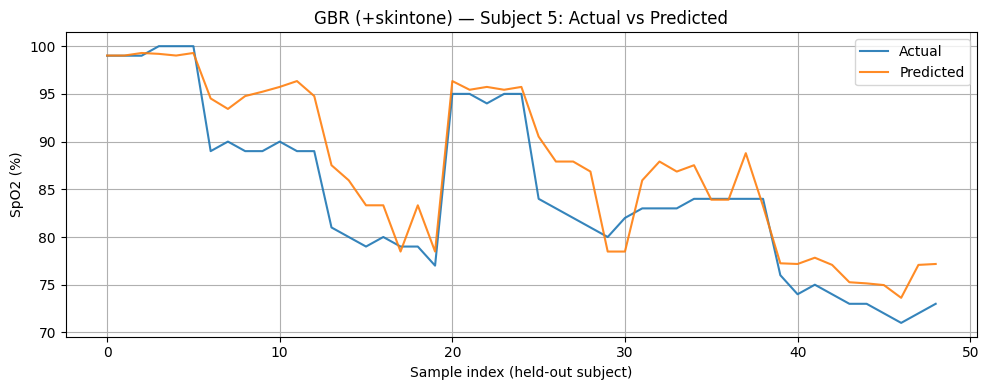

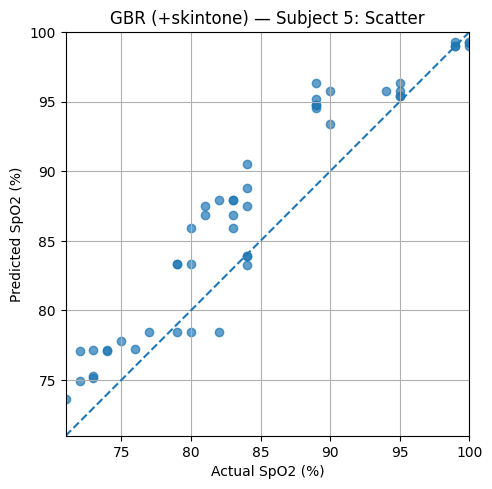

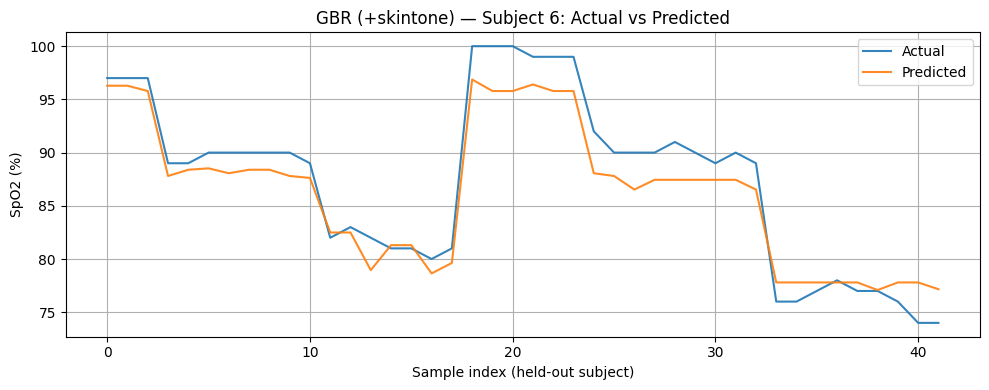

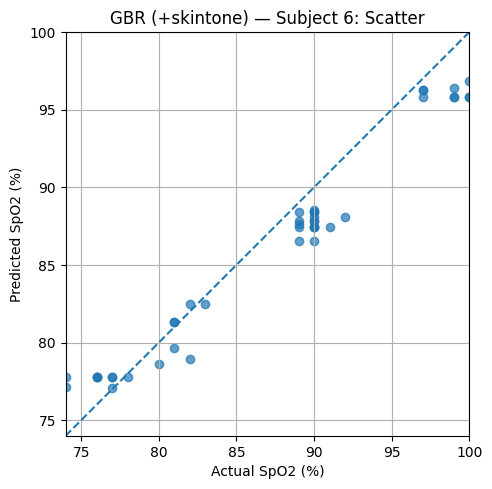

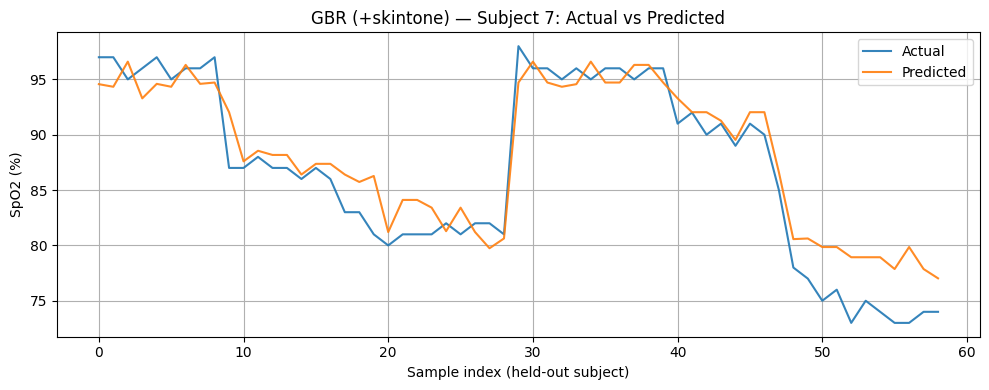

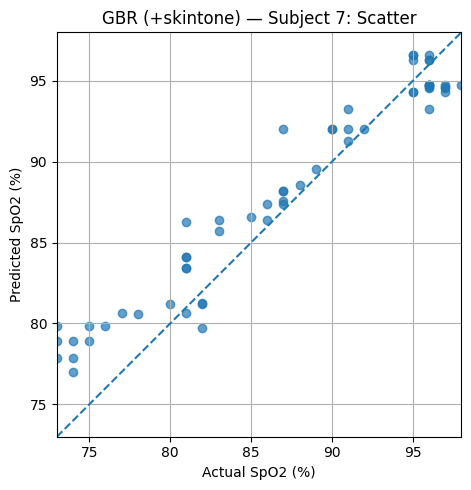

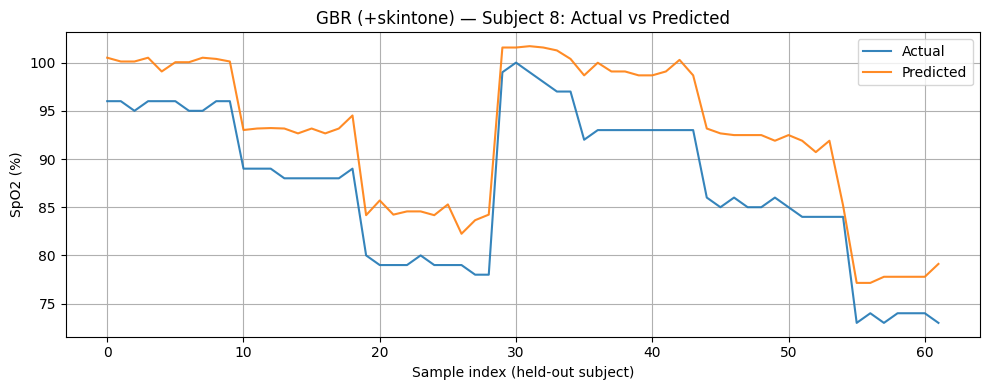

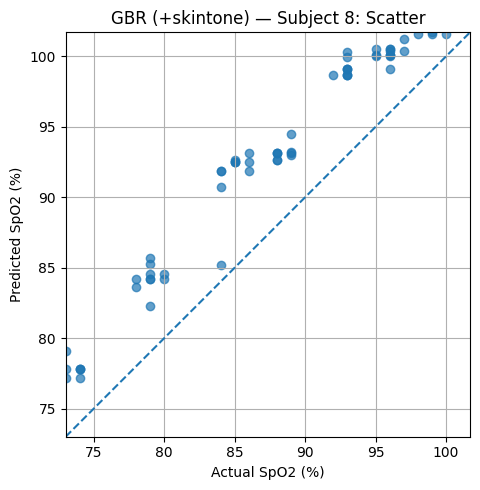

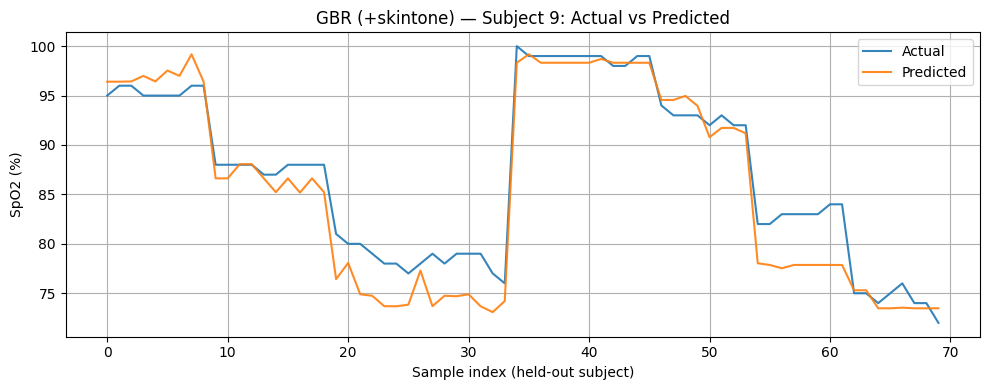

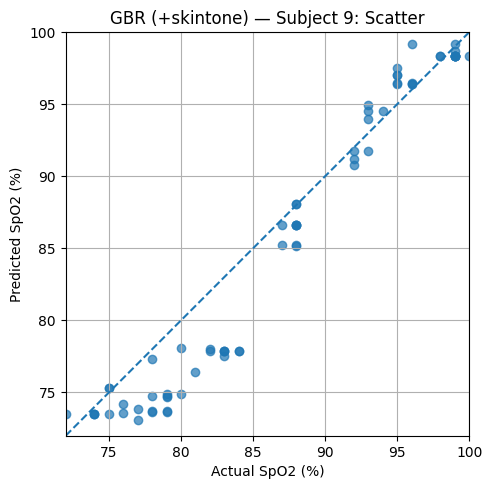

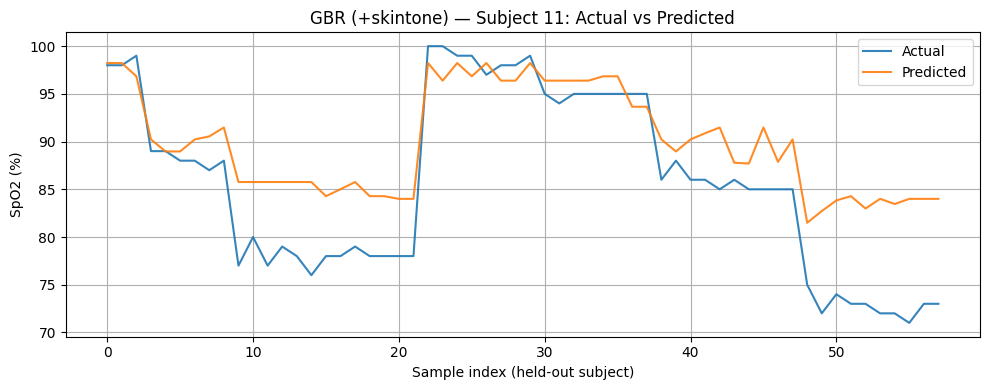

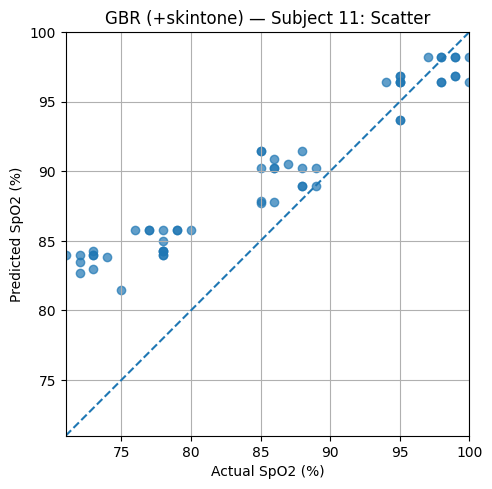

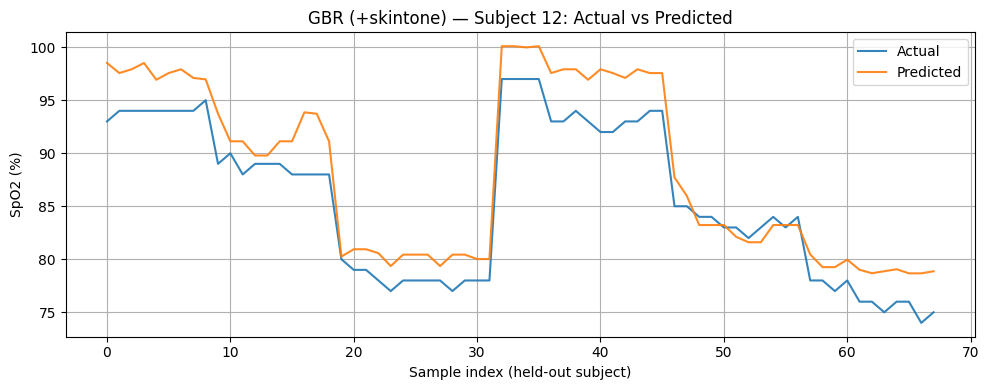

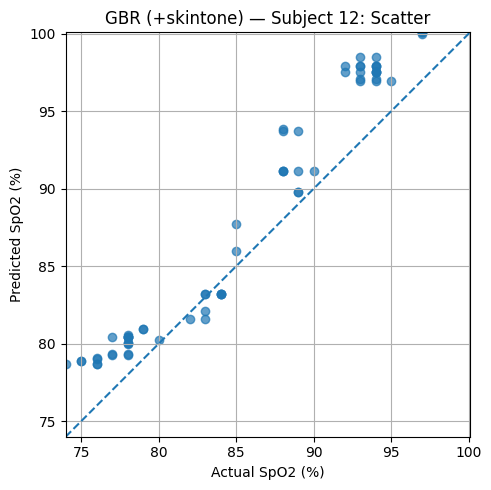

In [12]:
X_with_tone = df[["r_value", "skintone"]].values
metrics_gbr_with, preds_gbr_with = loso_eval_per_subject(X_with_tone, y, groups, gbr_fit_predict)
display(metrics_gbr_with)

plot_per_subject_bars(metrics_gbr_with, title_prefix="GBR (+skintone)")
plot_per_subject_predictions(preds_gbr_with, title_prefix="GBR (+skintone)", scatter_also=True)


SubjectNum       MAE      RMSE         r  n_test
0            1  4.997892  6.062939  0.858433      37
1            2  3.430588  4.108492  0.960498      32
2            3  2.037654  2.790219  0.940699      74
3            4  3.648920  4.807232  0.943714      53
4            5  3.172467  3.884693  0.921323      49
5            6  1.897604  2.367725  0.963678      42
6            7  2.155435  2.669660  0.953264      59
7            8  1.821475  2.241422  0.967828      62
8            9  1.726209  2.180517  0.972578      70
9           11  3.988808  4.900205  0.939529      58
10          12  2.121098  2.463267  0.969172      68

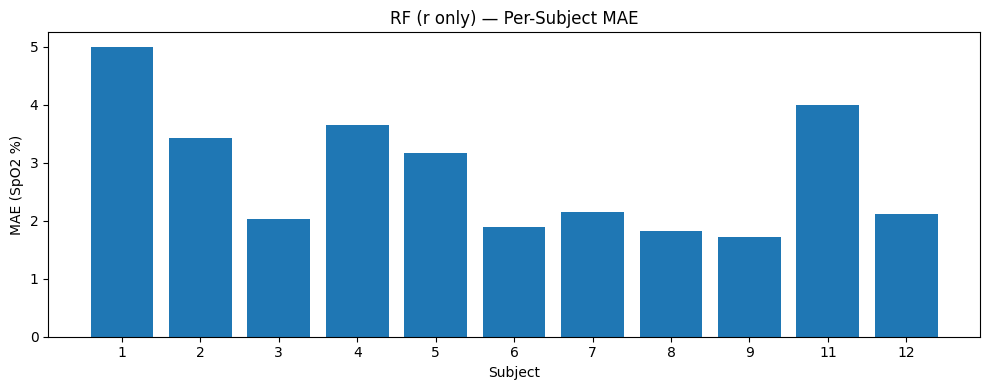

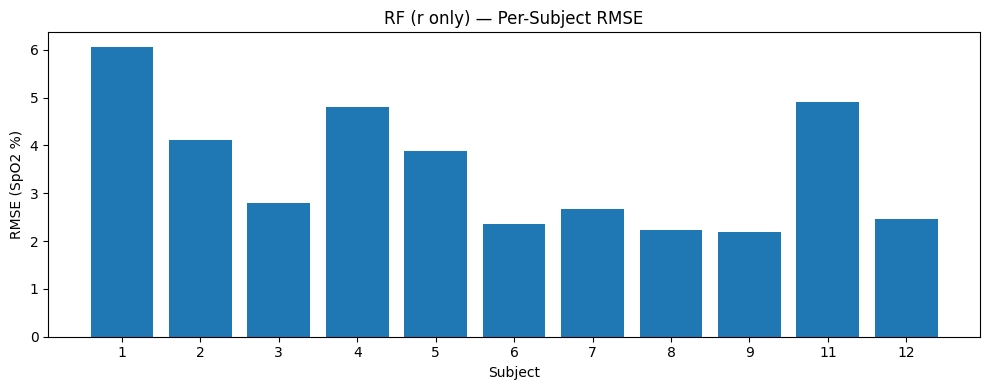

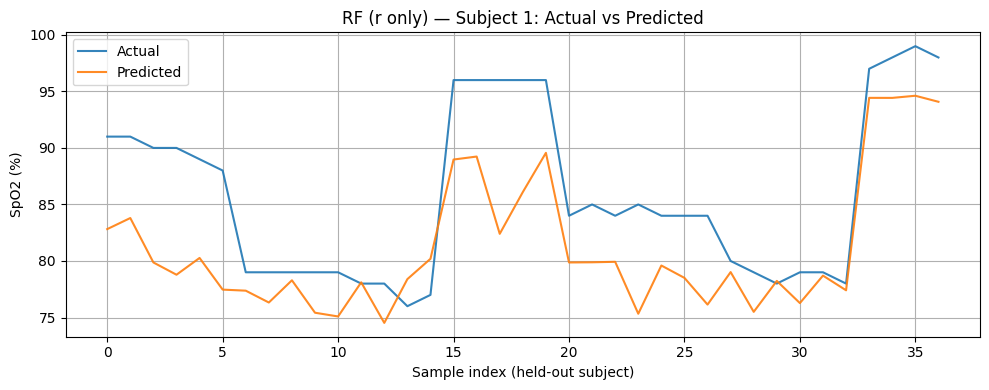

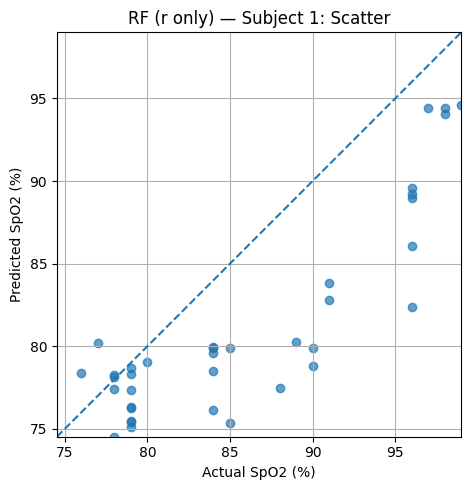

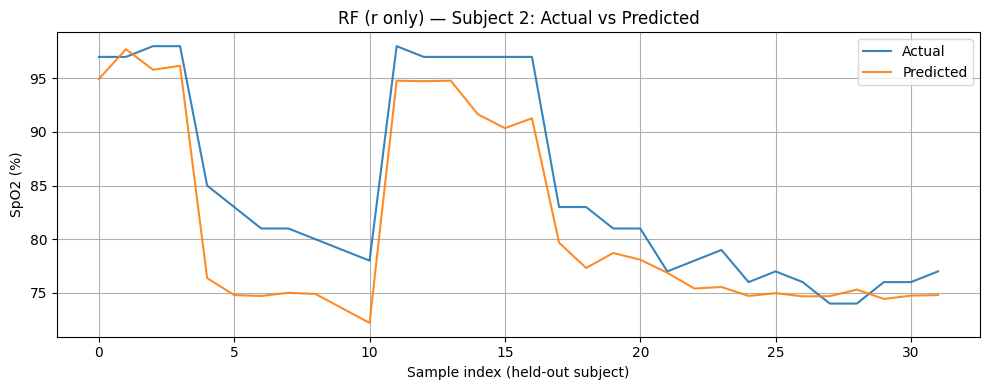

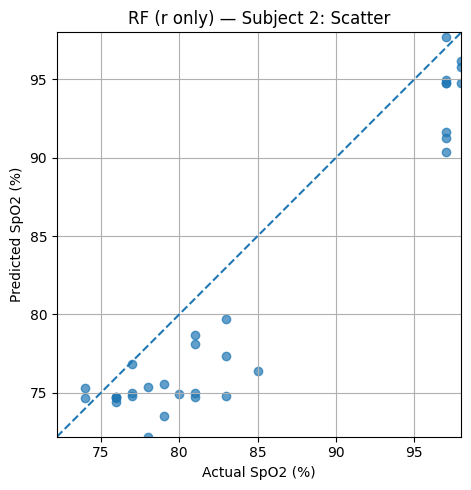

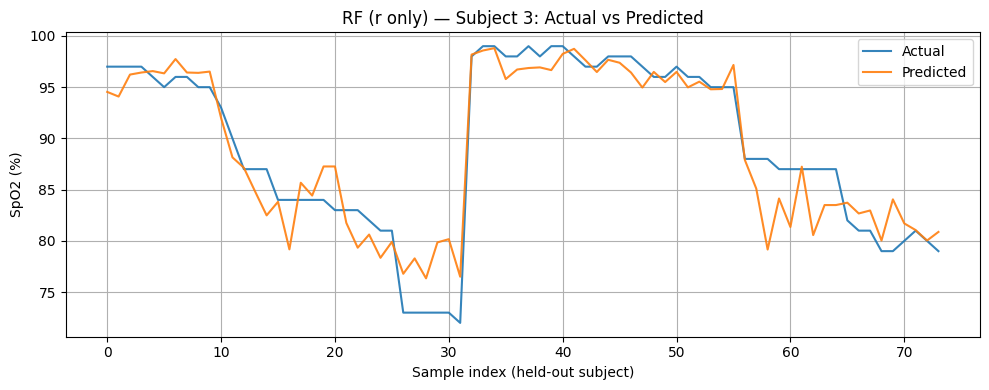

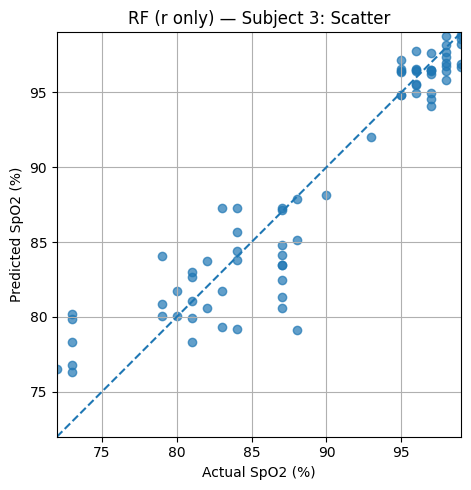

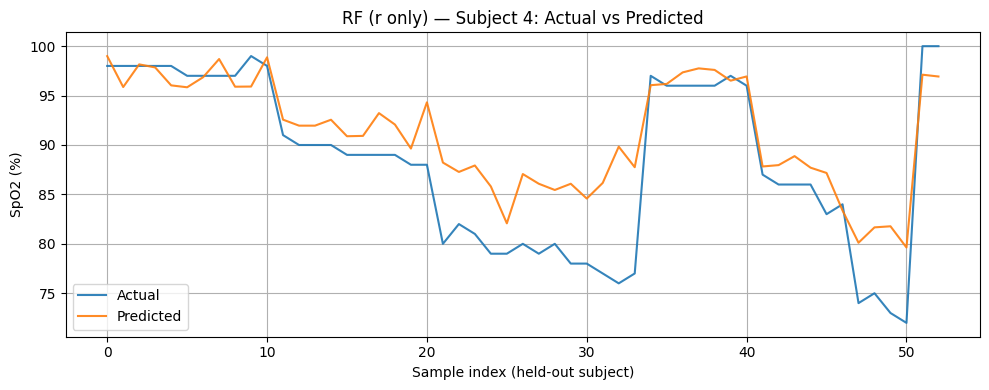

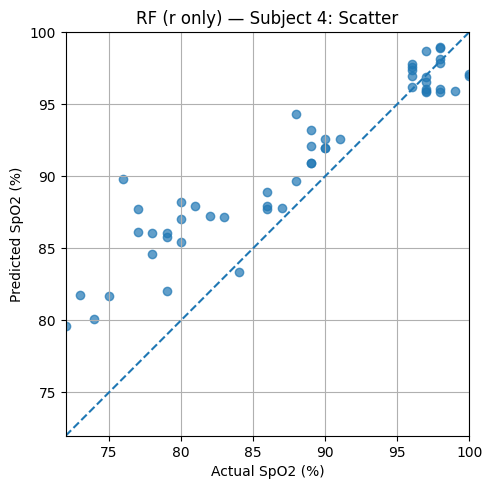

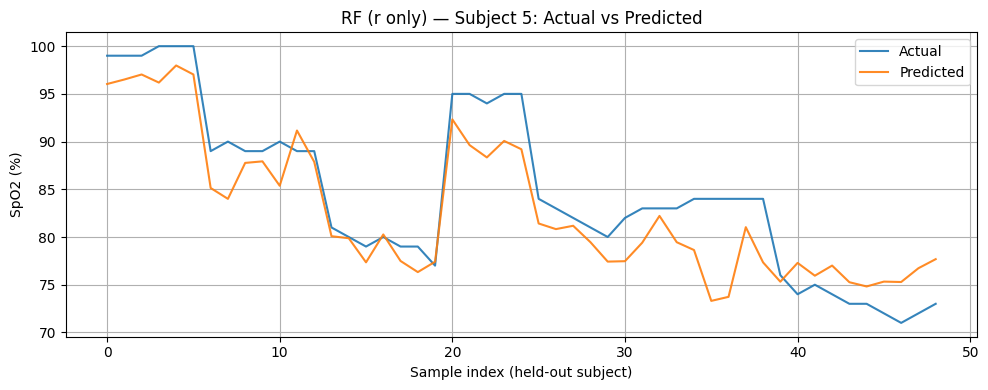

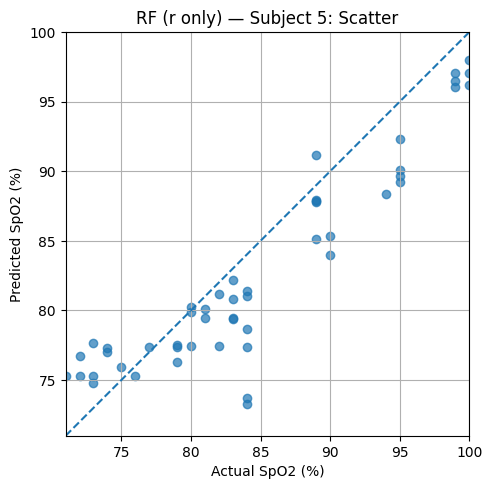

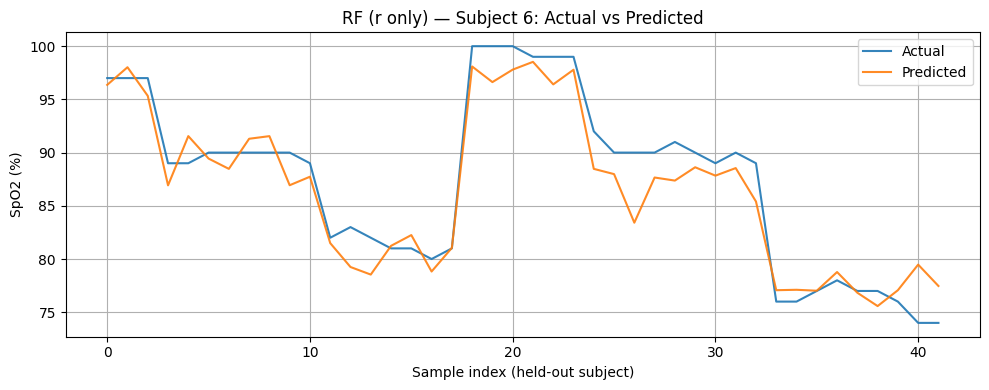

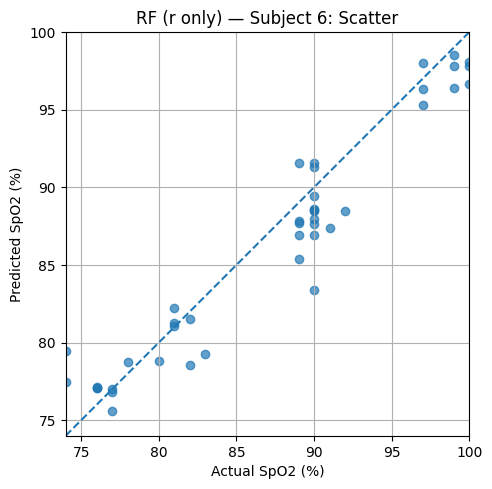

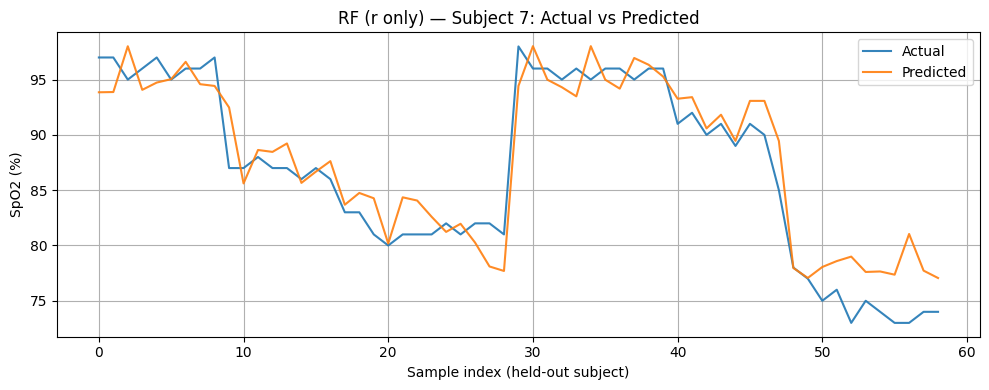

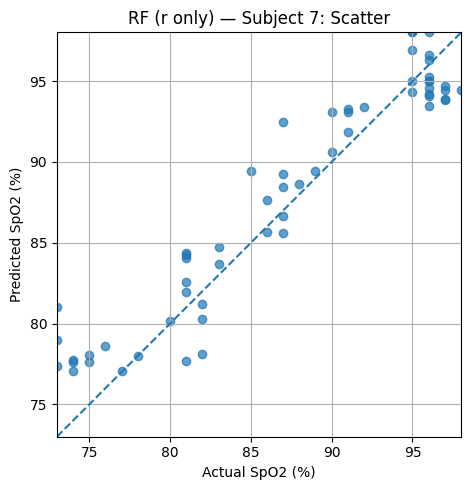

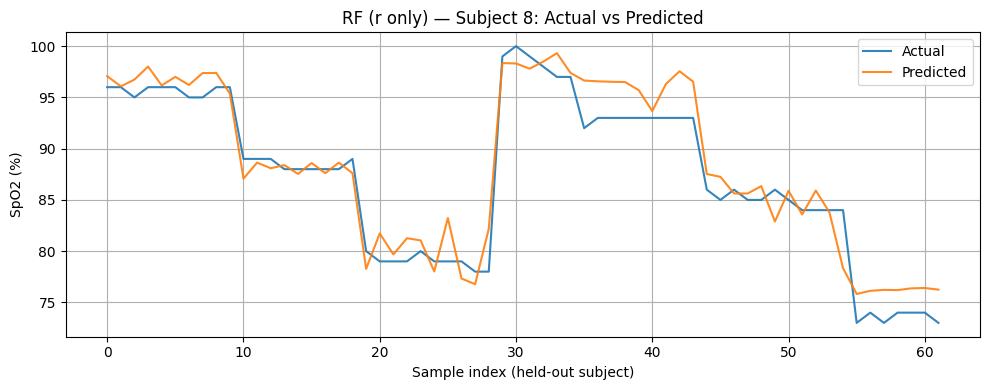

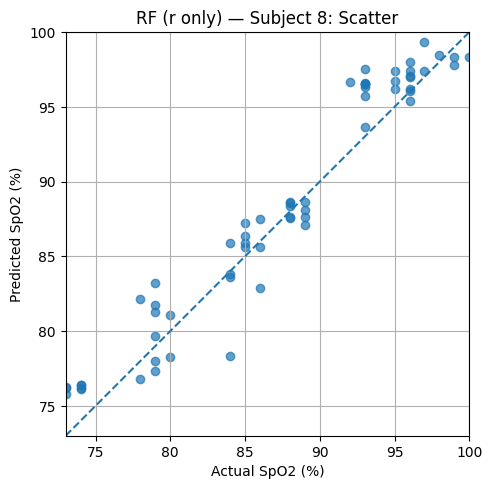

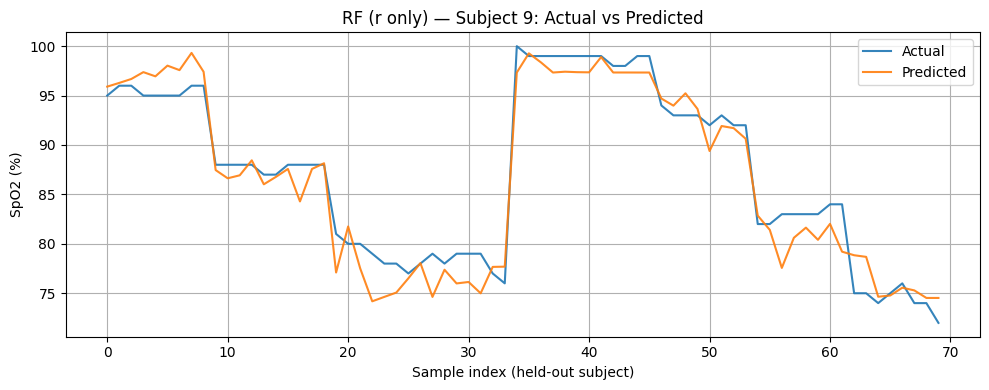

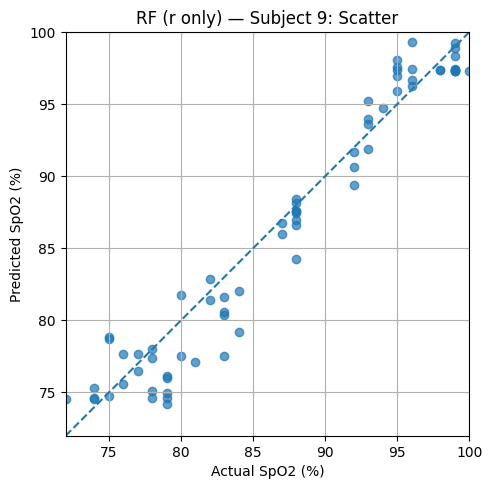

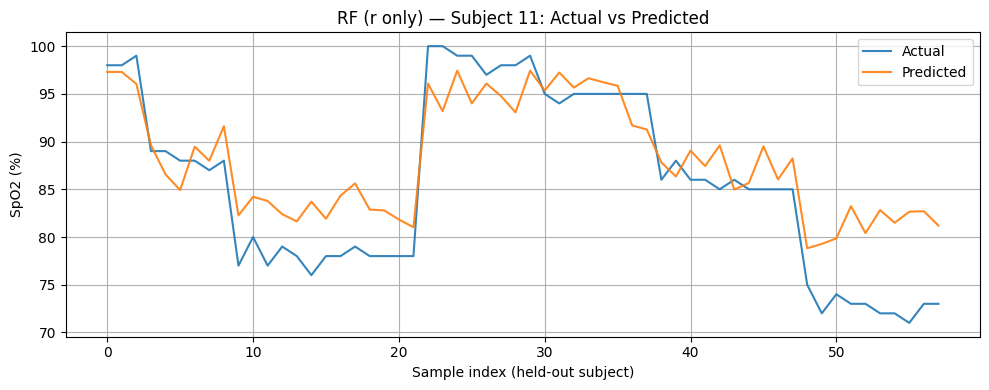

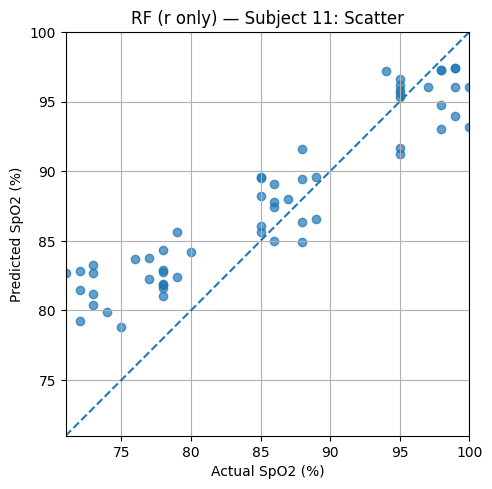

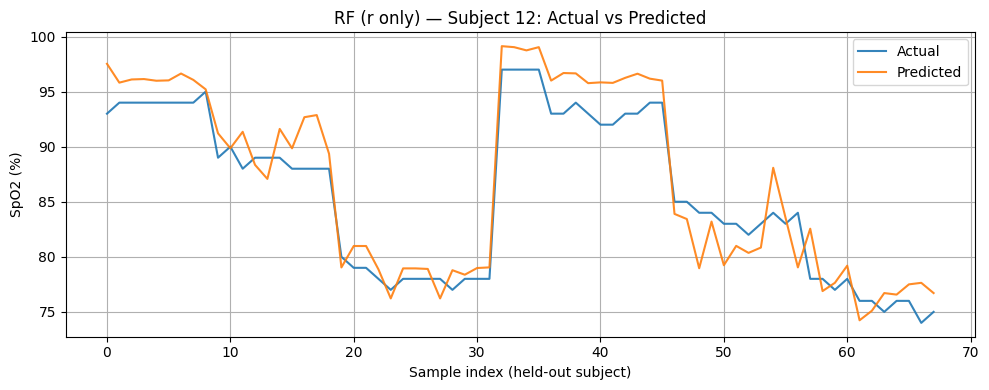

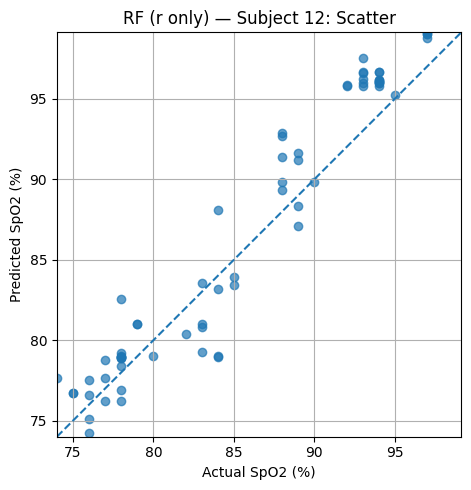

SubjectNum       MAE      RMSE         r  n_test
0            1  5.279056  6.050750  0.898490      37
1            2  3.591979  4.544602  0.945193      32
2            3  3.486176  4.181122  0.936853      74
3            4  3.722286  5.009148  0.954923      53
4            5  3.080527  3.467376  0.953845      49
5            6  1.822495  2.136632  0.985309      42
6            7  2.587100  3.177395  0.969959      59
7            8  3.640103  4.087743  0.970573      62
8            9  1.984686  2.579387  0.980724      70
9           11  3.748648  4.741545  0.972449      58
10          12  2.749434  3.200181  0.948307      68

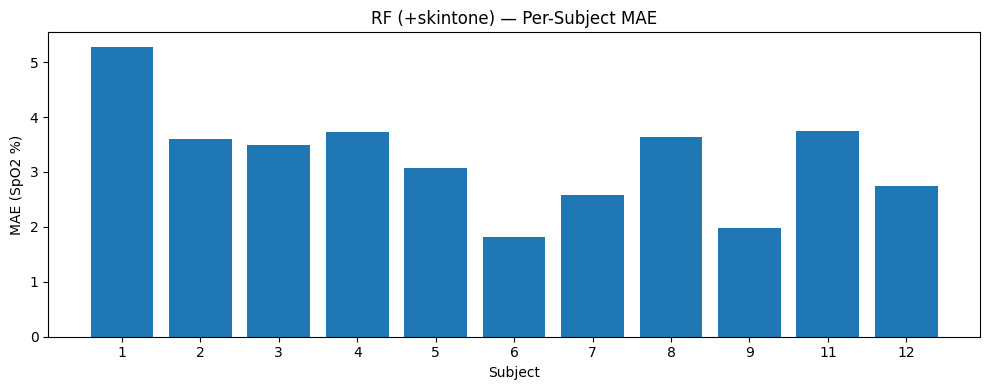

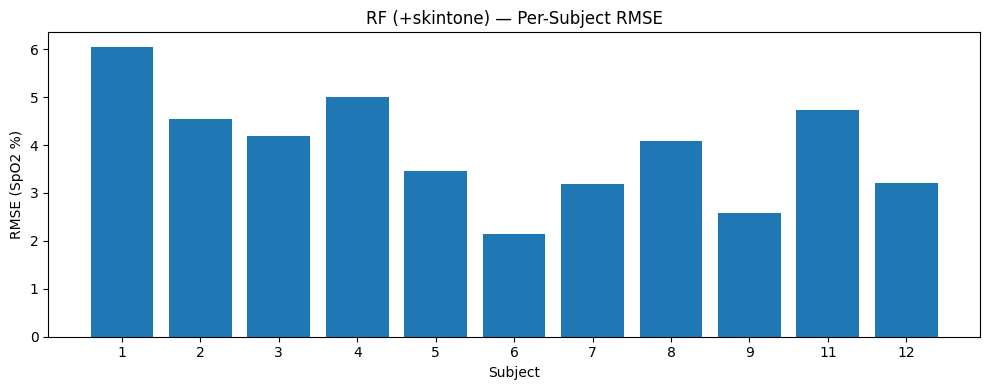

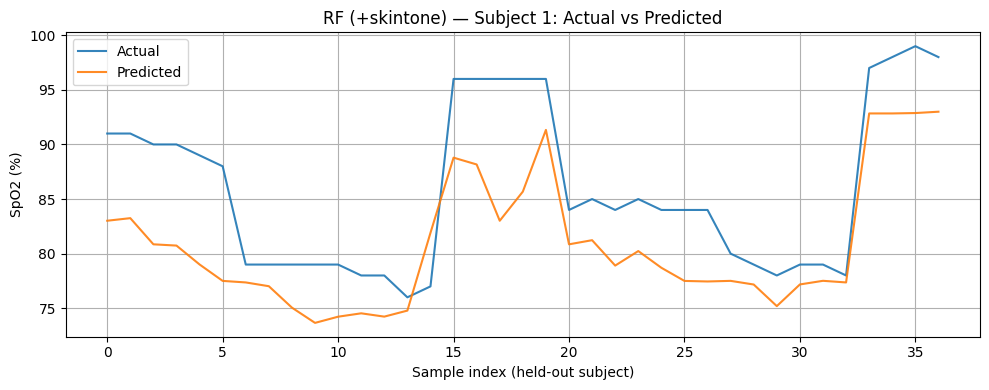

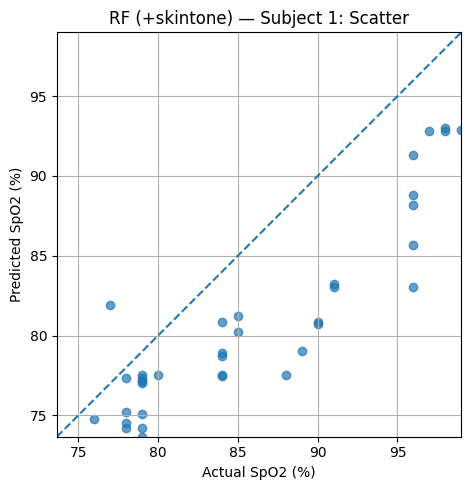

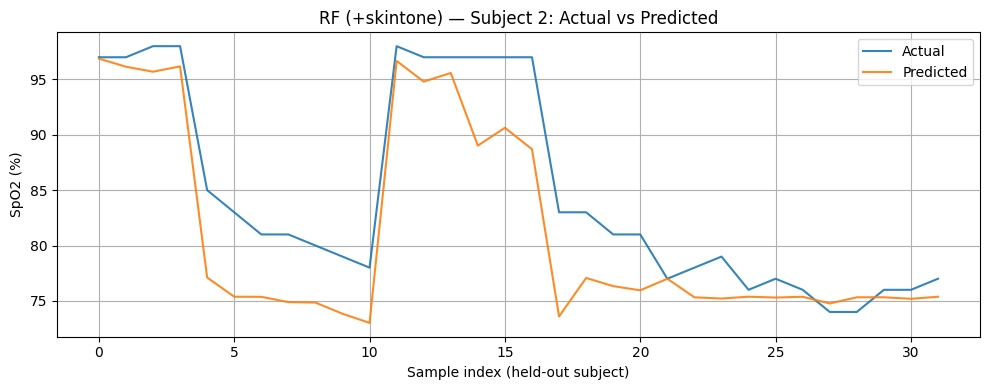

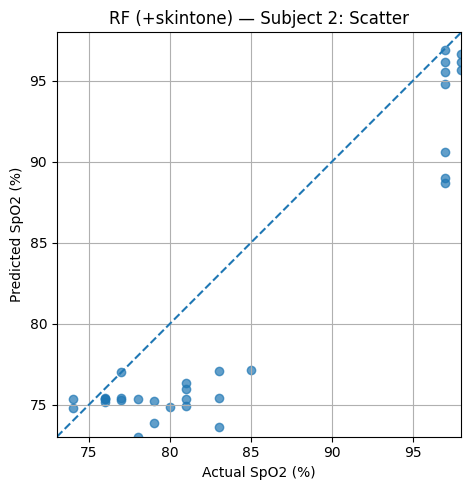

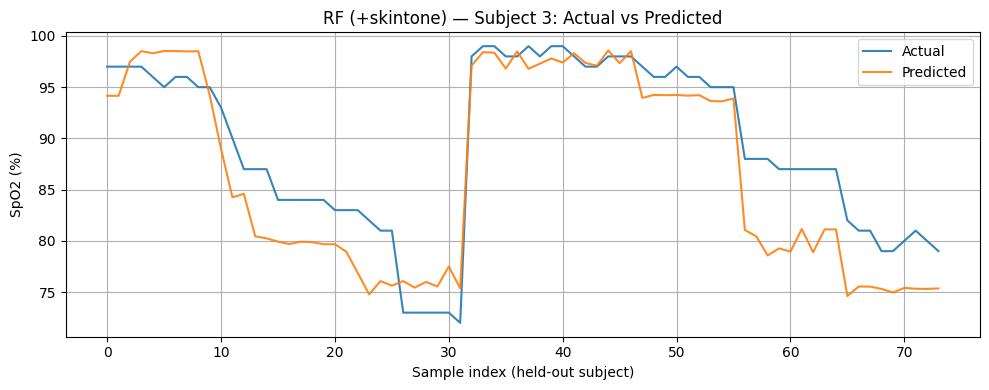

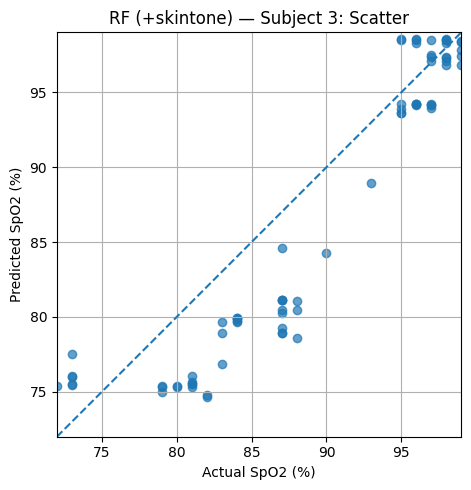

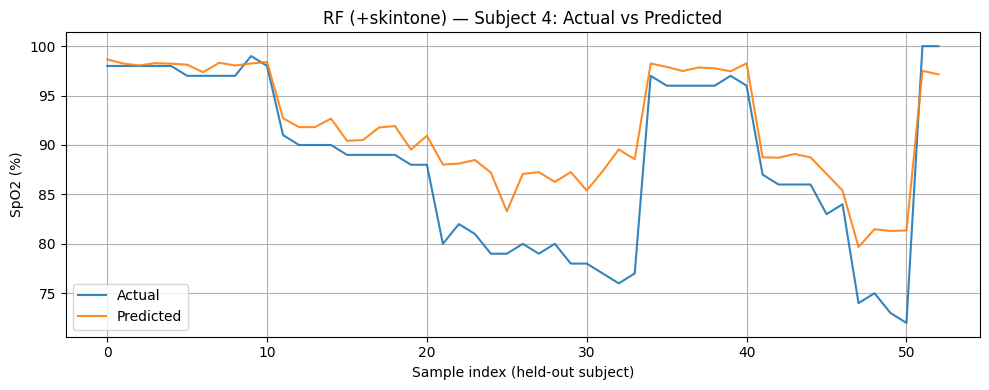

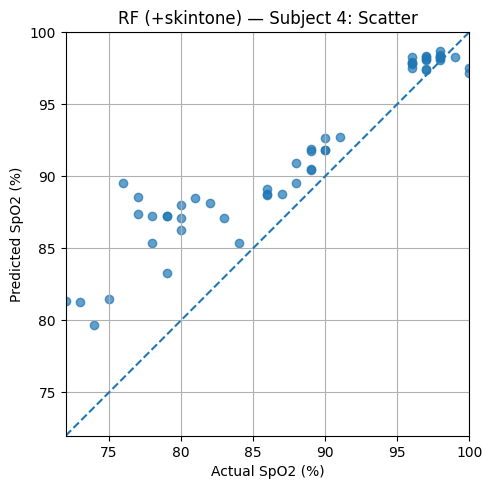

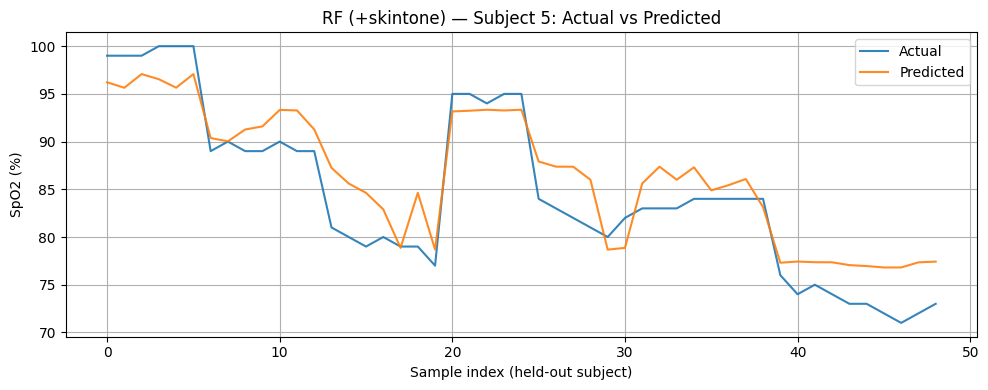

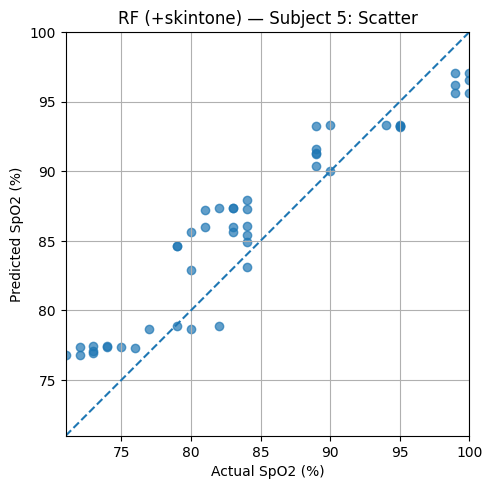

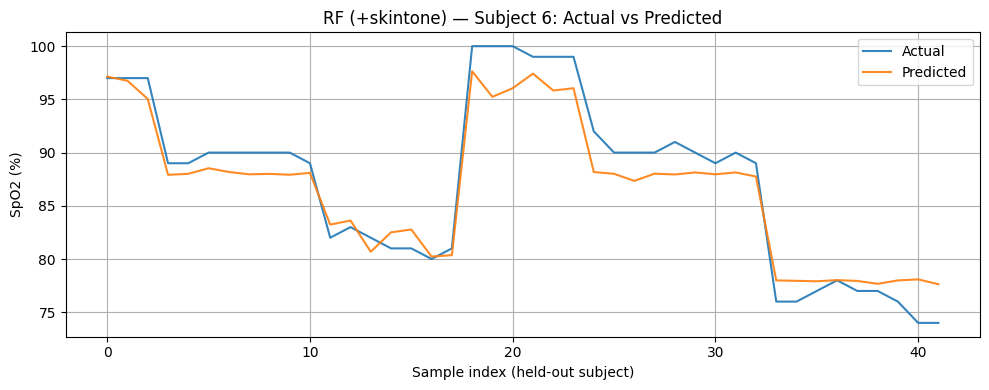

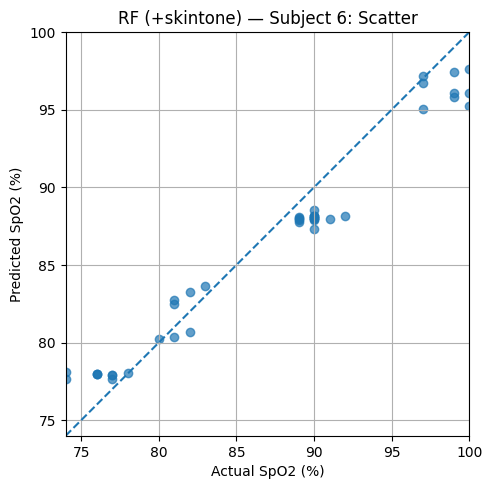

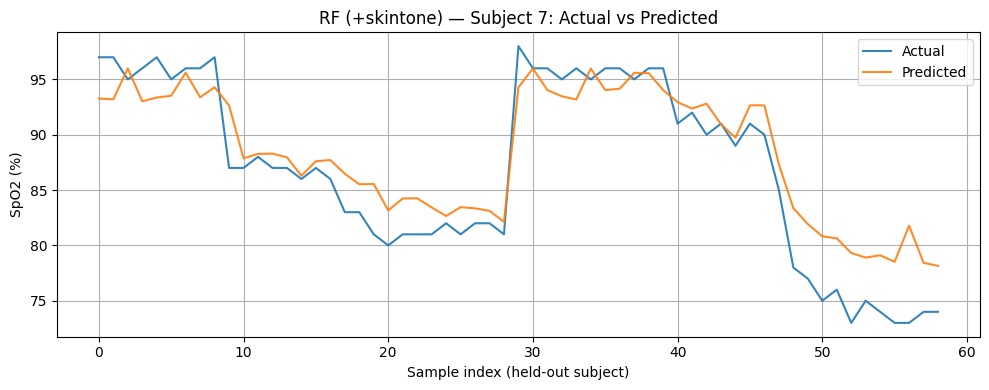

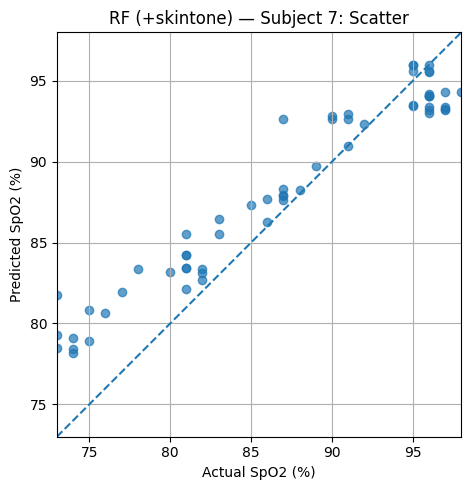

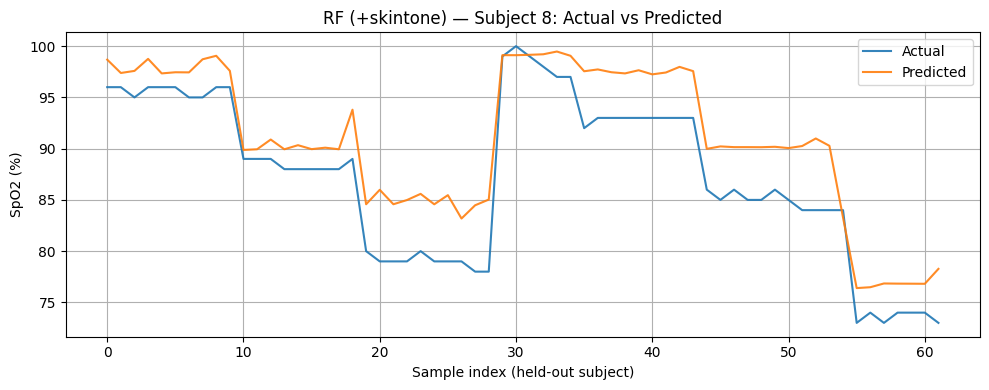

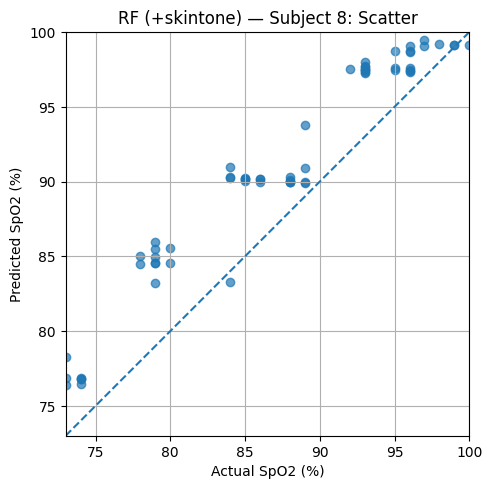

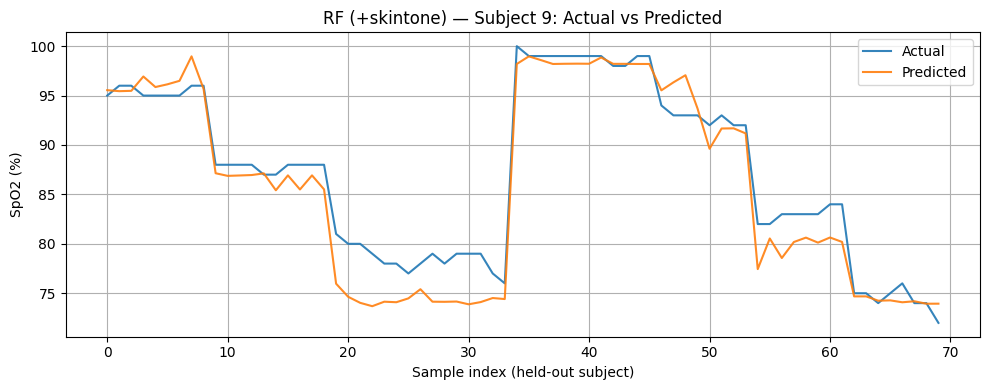

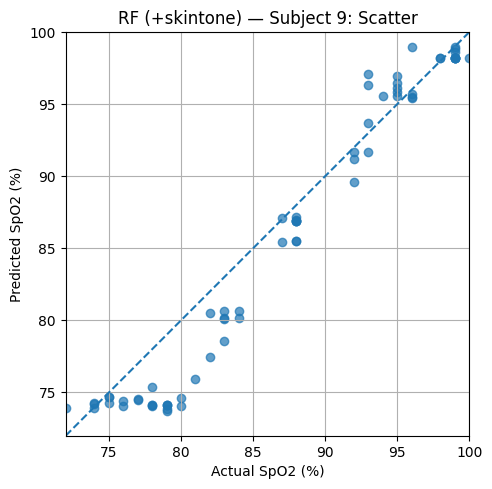

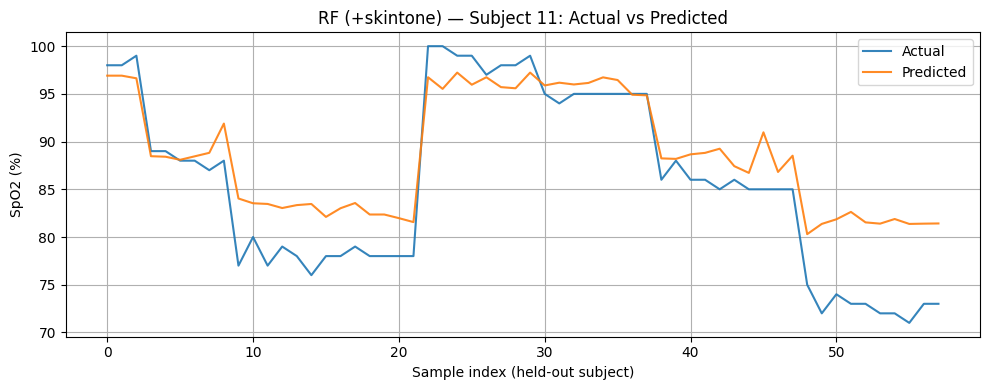

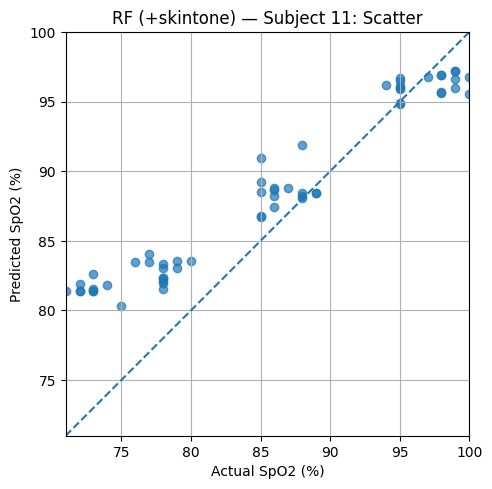

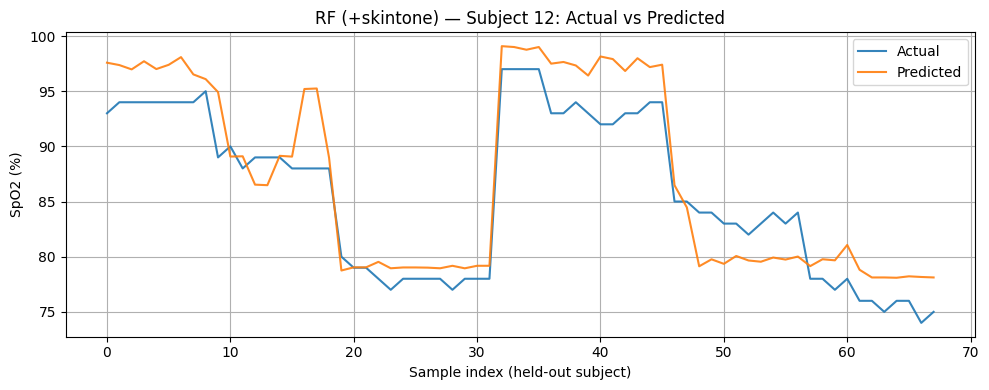

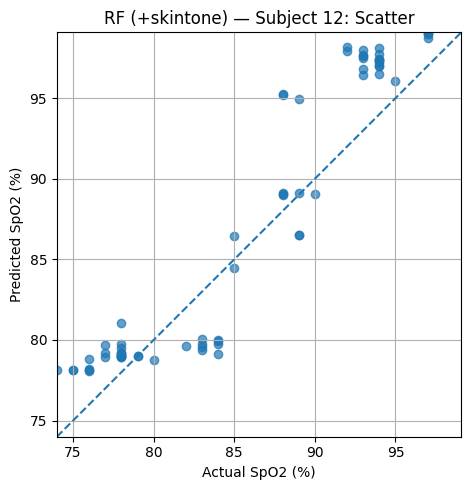

In [13]:
def rf_fit_predict(Xtr, ytr, Xte):
    model = RandomForestRegressor(
        n_estimators=400, max_depth=None, min_samples_leaf=2, random_state=RANDOM_STATE, n_jobs=-1
    )
    model.fit(Xtr, ytr)
    return model.predict(Xte)

# r only
metrics_rf_no, preds_rf_no = loso_eval_per_subject(X_no_tone, y, groups, rf_fit_predict)
display(metrics_rf_no)
plot_per_subject_bars(metrics_rf_no, title_prefix="RF (r only)")
plot_per_subject_predictions(preds_rf_no, title_prefix="RF (r only)", scatter_also=True)

# + skintone
metrics_rf_with, preds_rf_with = loso_eval_per_subject(X_with_tone, y, groups, rf_fit_predict)
display(metrics_rf_with)
plot_per_subject_bars(metrics_rf_with, title_prefix="RF (+skintone)")
plot_per_subject_predictions(preds_rf_with, title_prefix="RF (+skintone)", scatter_also=True)


SubjectNum       MAE      RMSE         r  n_test
0            1  4.628107  5.621003  0.895740      37
1            2  4.627986  5.287321  0.961396      32
2            3  1.591919  2.023801  0.988517      74
3            4  3.751268  5.088301  0.960733      53
4            5  1.792597  2.281182  0.983420      49
5            6  1.731148  2.106033  0.985037      42
6            7  2.150369  2.630489  0.977319      59
7            8  1.234442  1.511154  0.991670      62
8            9  1.540266  1.824509  0.994555      70
9           11  4.549601  5.447438  0.974052      58
10          12  1.209358  1.547130  0.987874      68

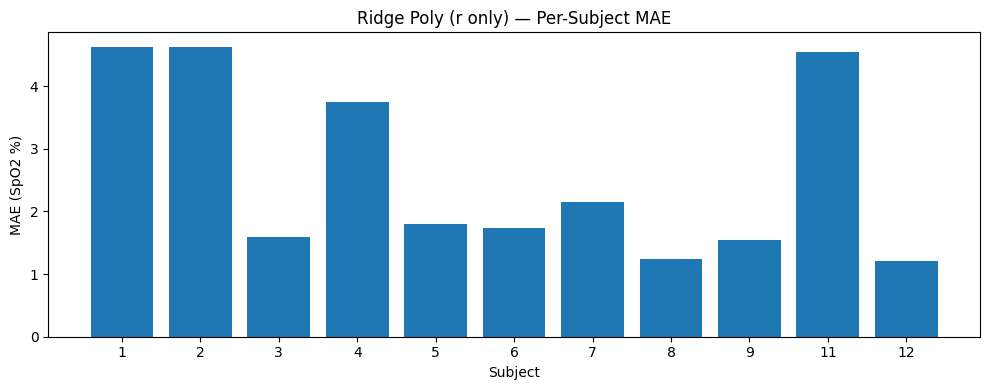

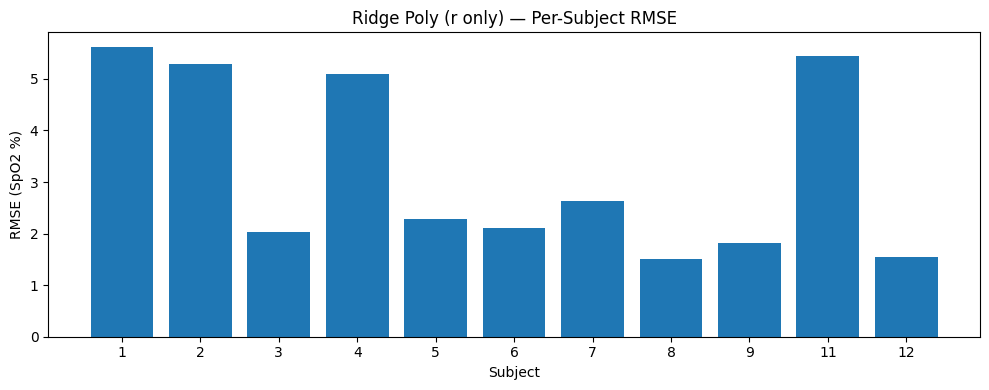

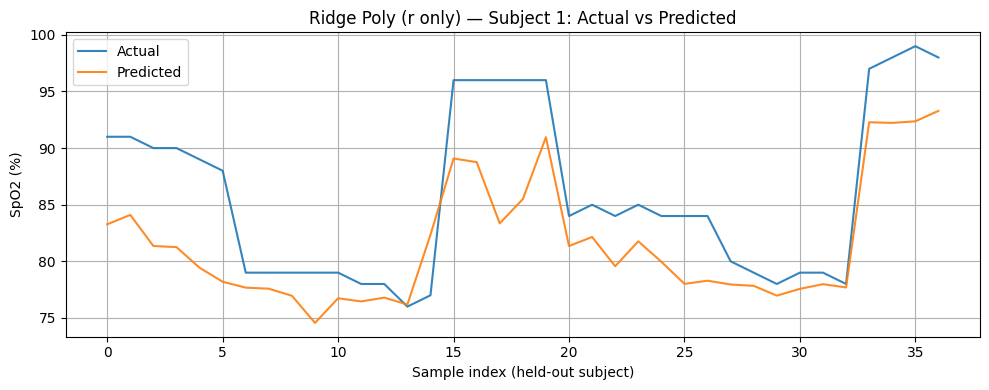

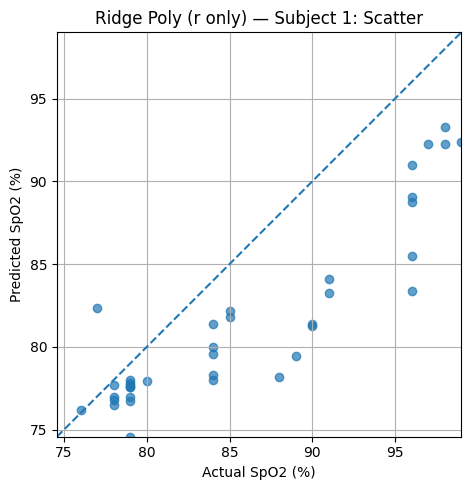

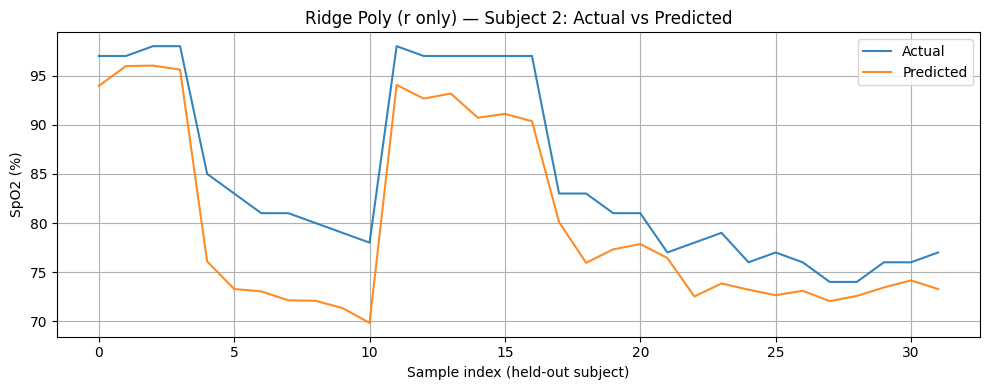

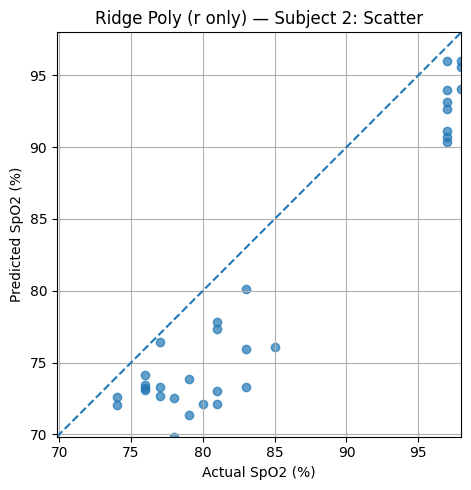

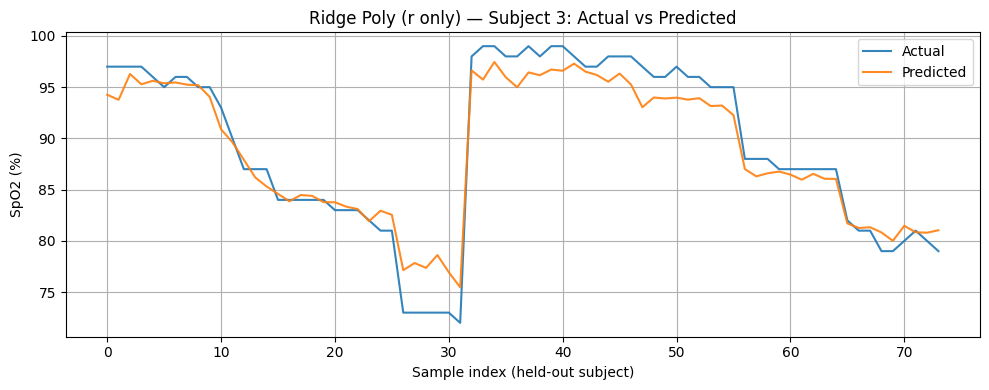

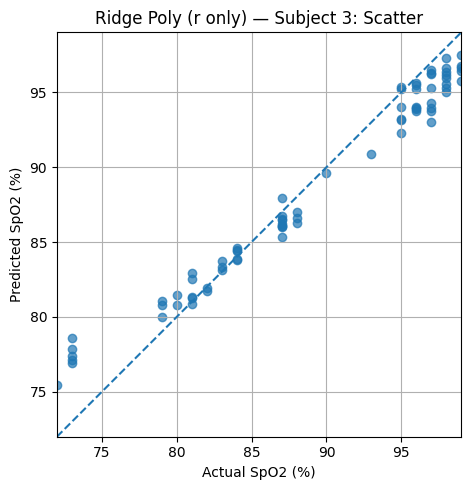

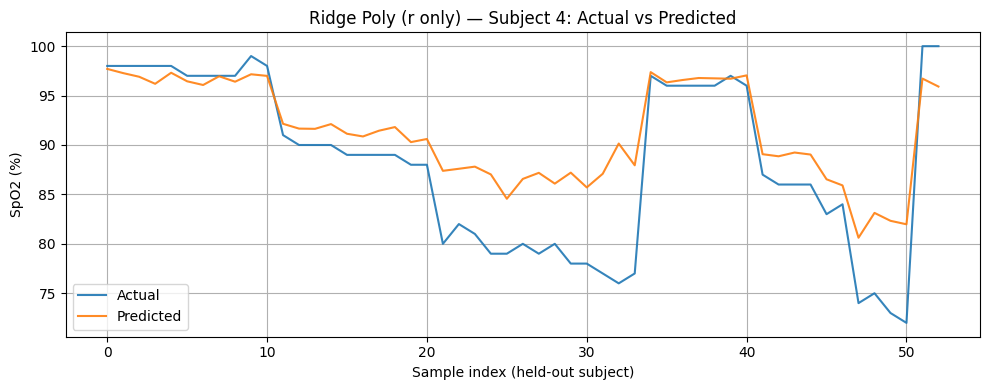

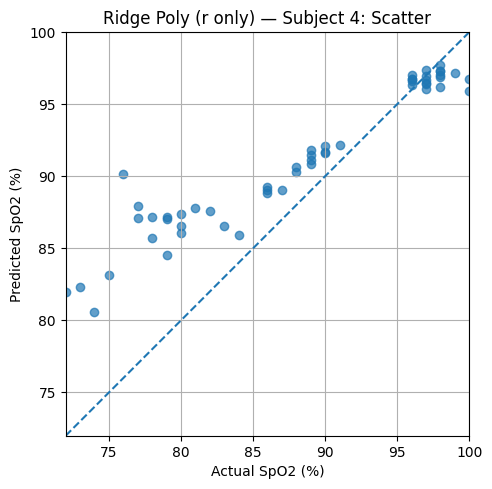

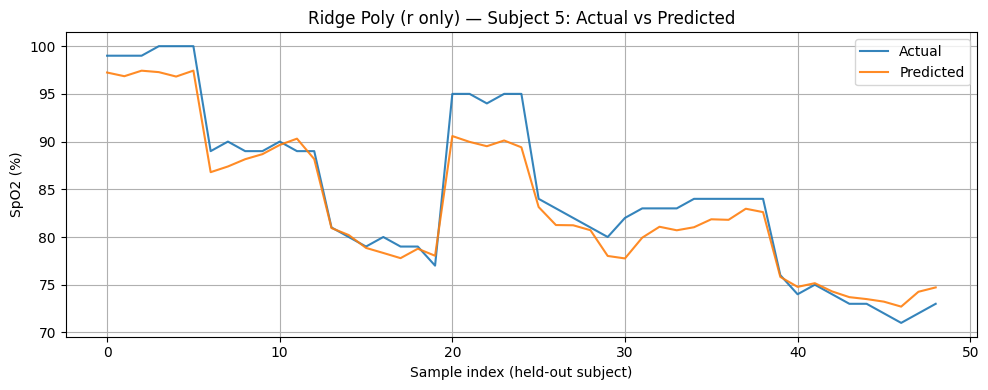

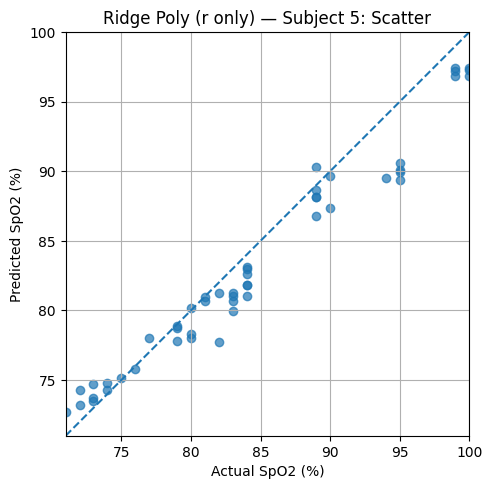

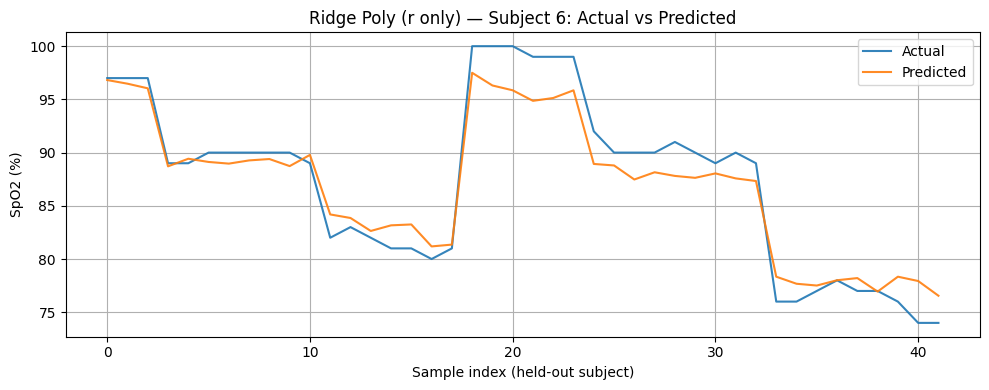

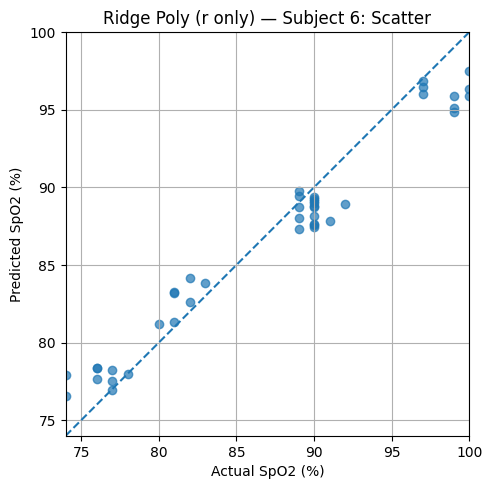

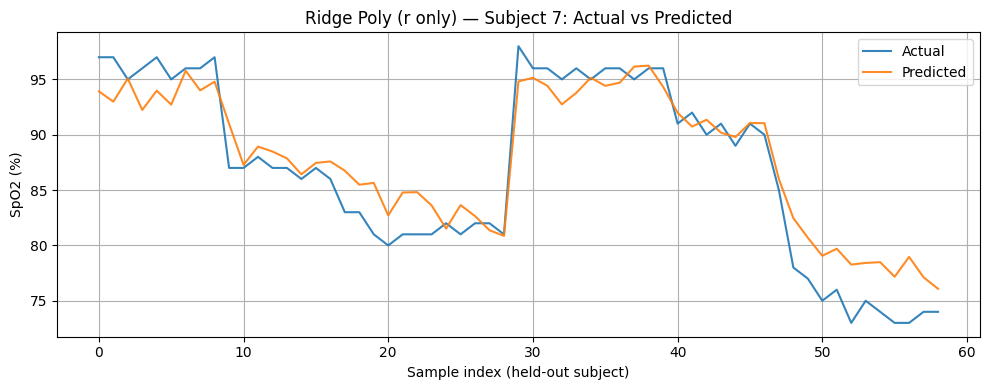

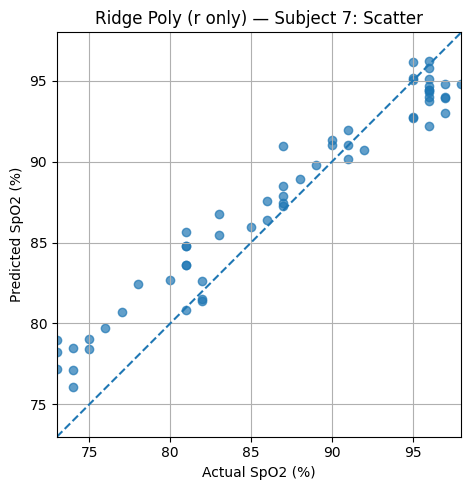

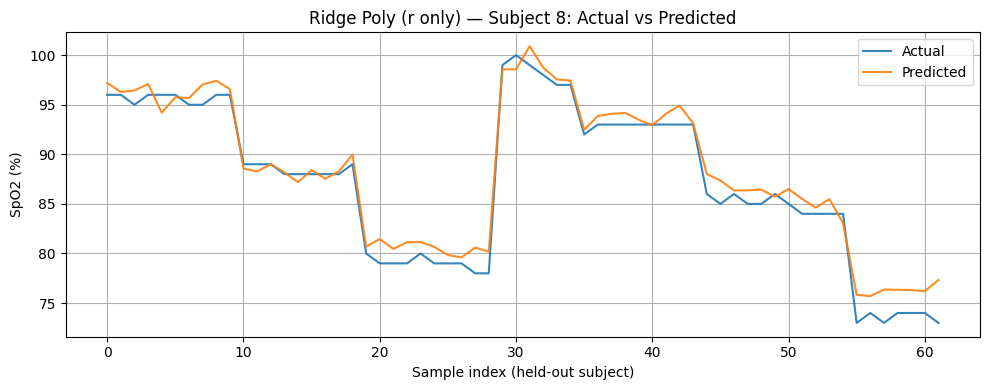

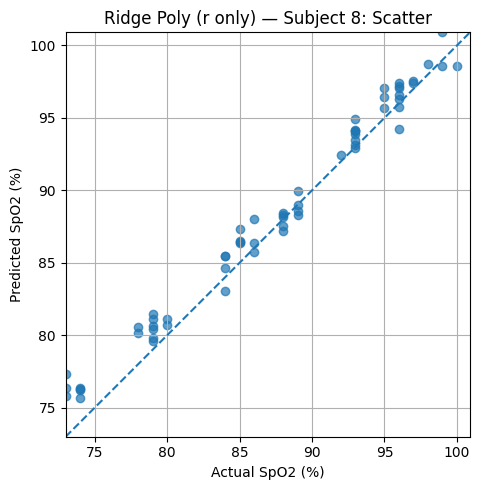

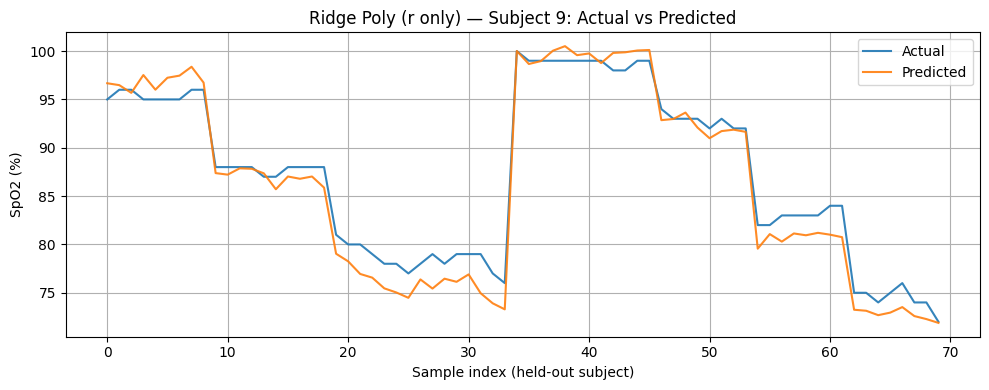

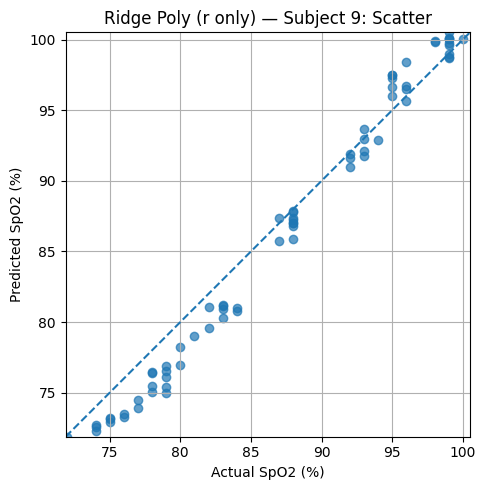

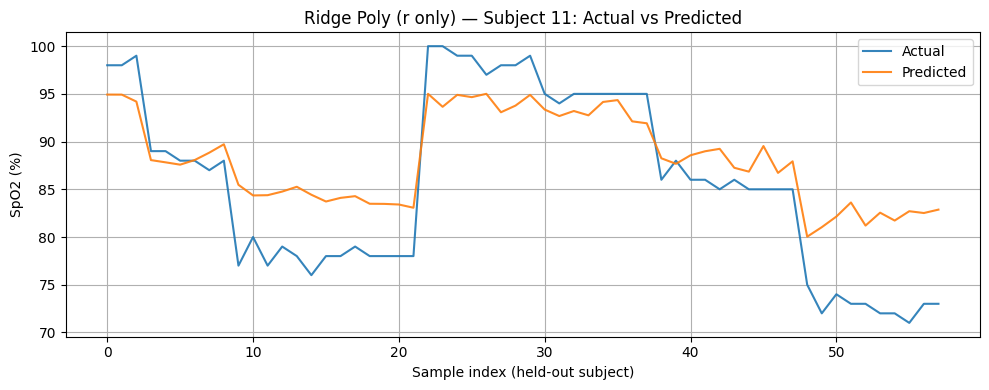

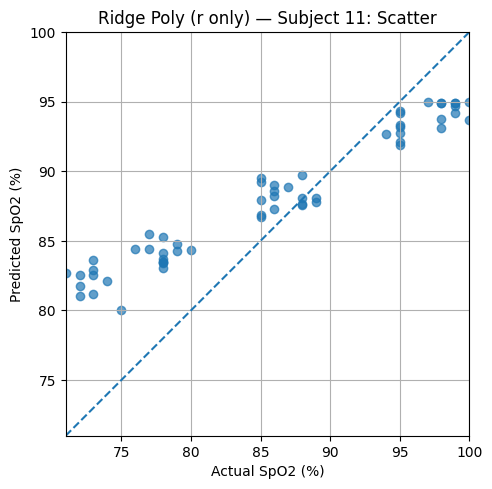

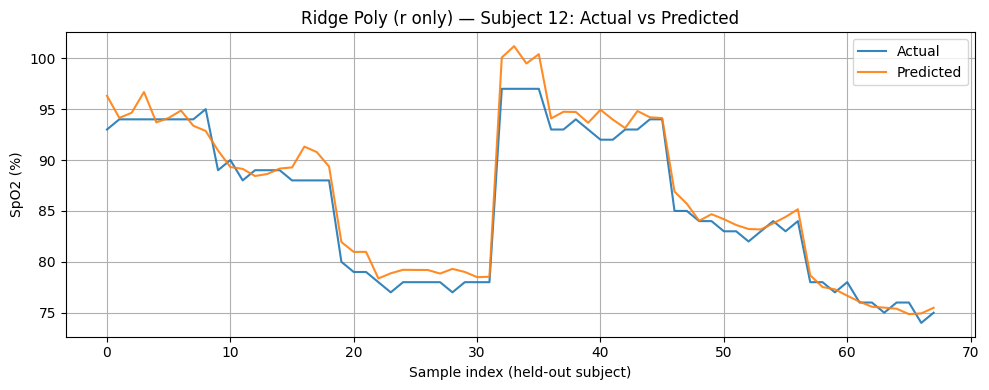

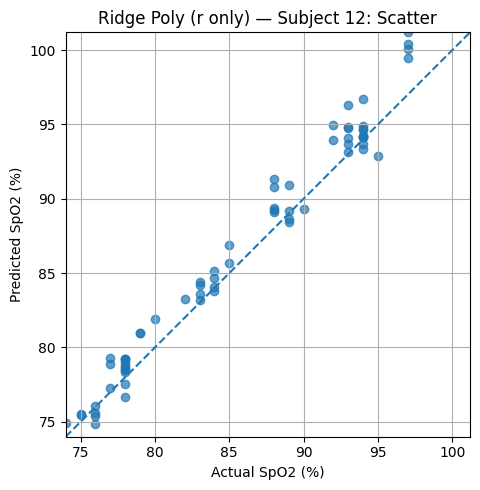

SubjectNum       MAE      RMSE         r  n_test
0            1  4.140482  5.188758  0.896131      37
1            2  5.188183  5.845779  0.960885      32
2            3  2.320245  2.619745  0.988768      74
3            4  3.473563  4.730487  0.960704      53
4            5  1.468360  1.814447  0.983837      49
5            6  1.827684  2.246587  0.985069      42
6            7  2.267472  2.761529  0.977195      59
7            8  2.591548  2.791796  0.992017      62
8            9  1.597172  1.867908  0.994789      70
9           11  4.472202  5.334624  0.974064      58
10          12  1.056476  1.402400  0.987922      68

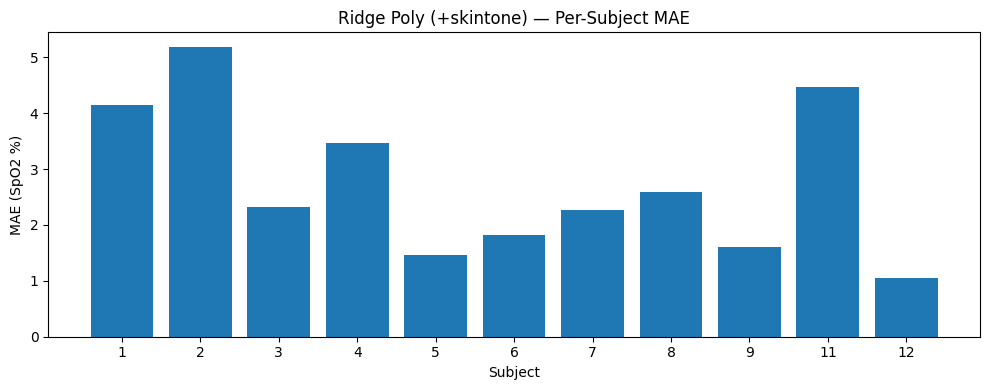

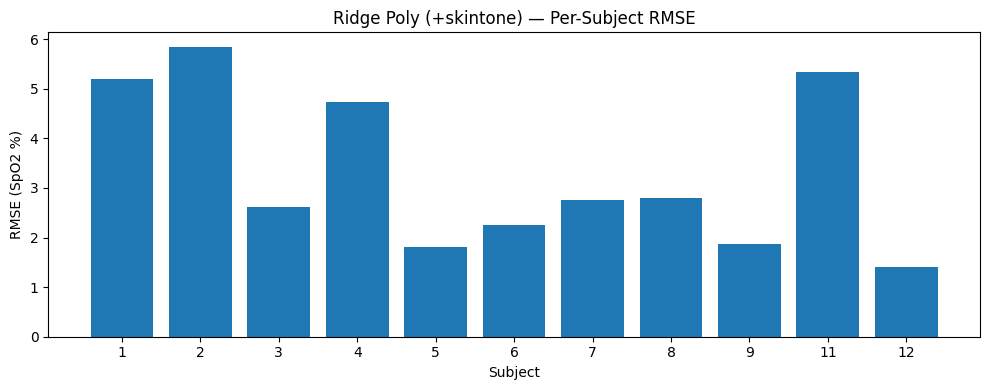

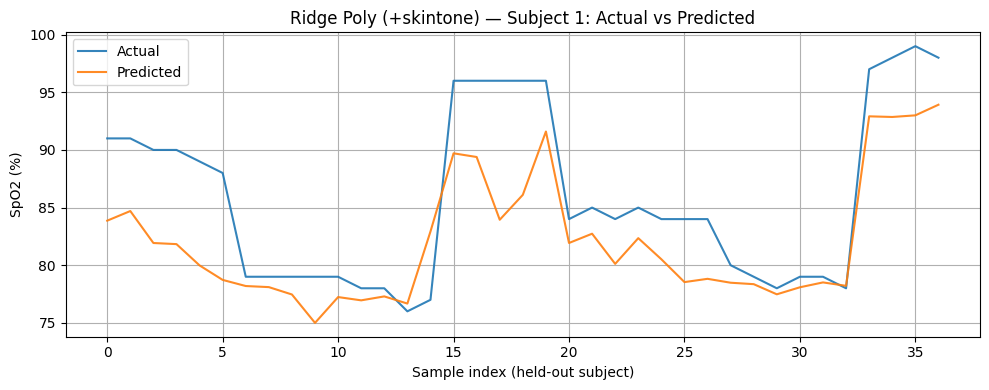

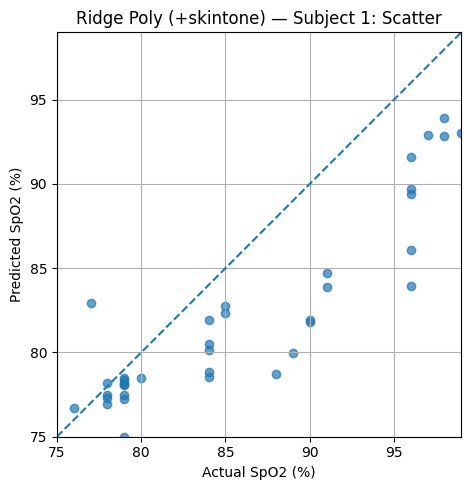

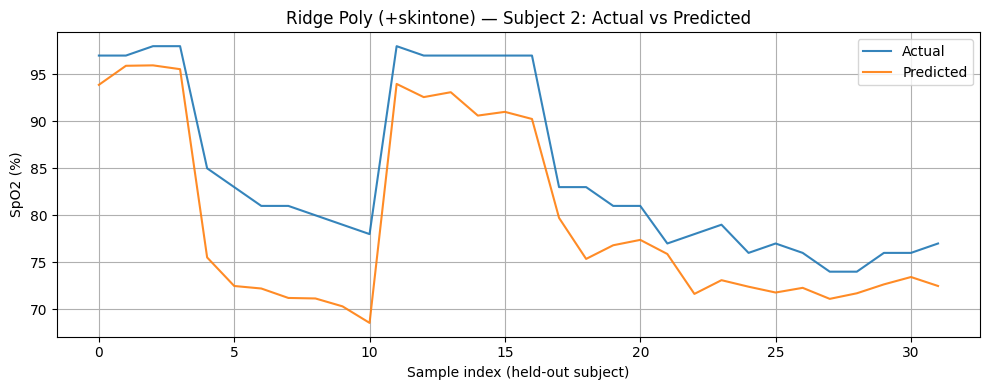

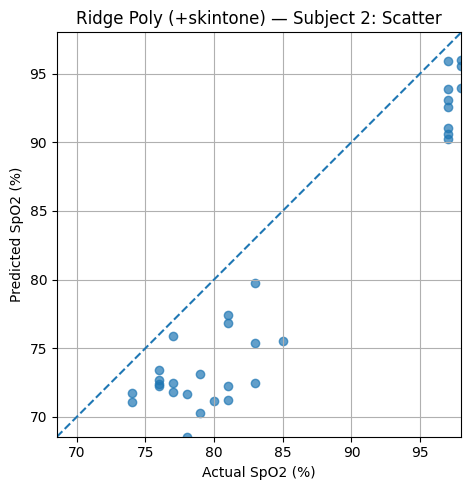

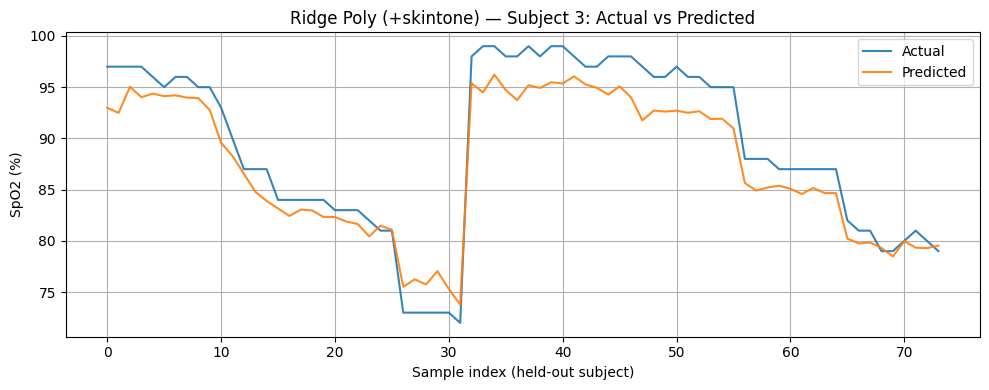

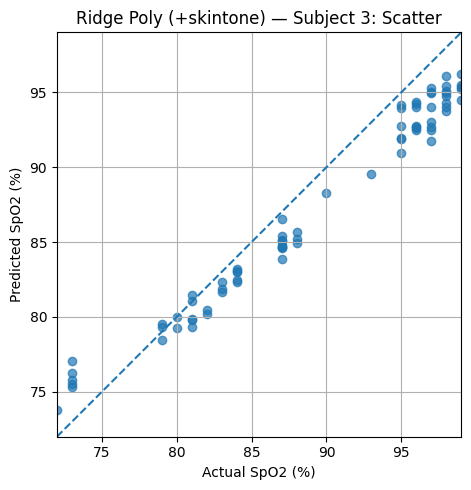

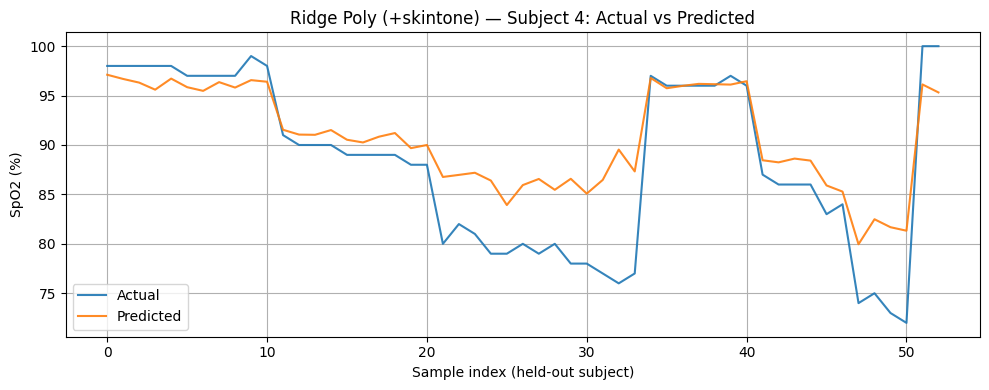

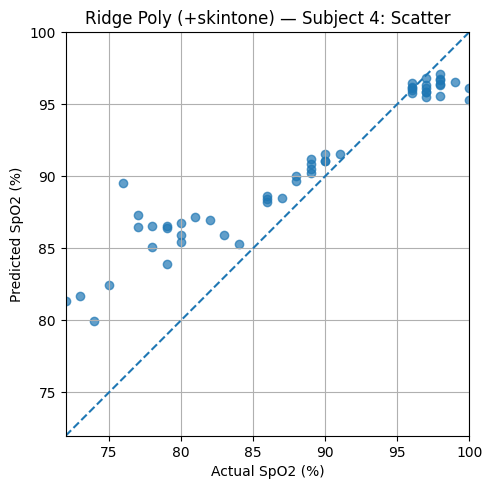

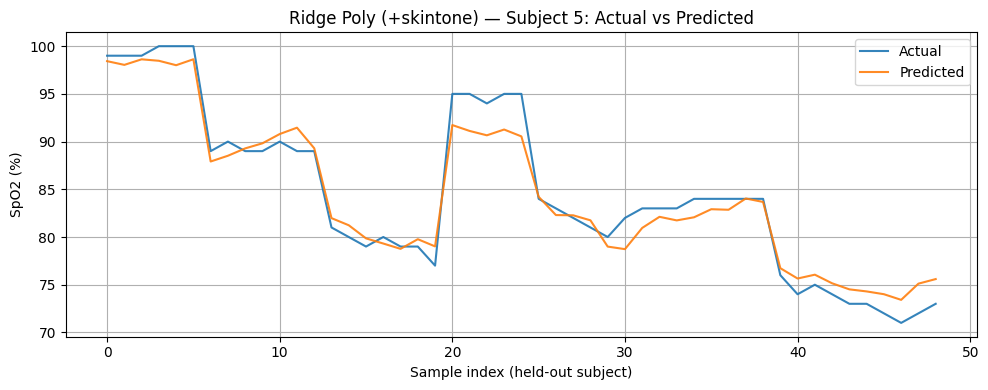

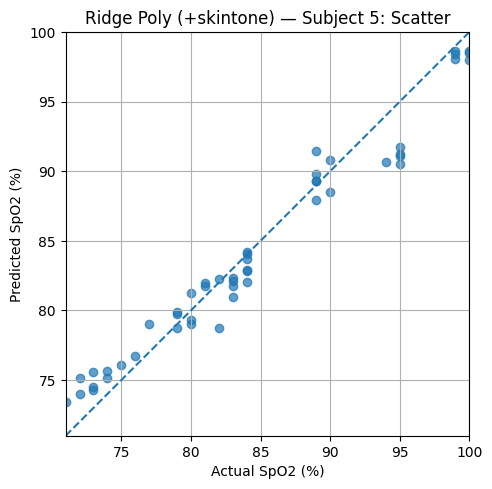

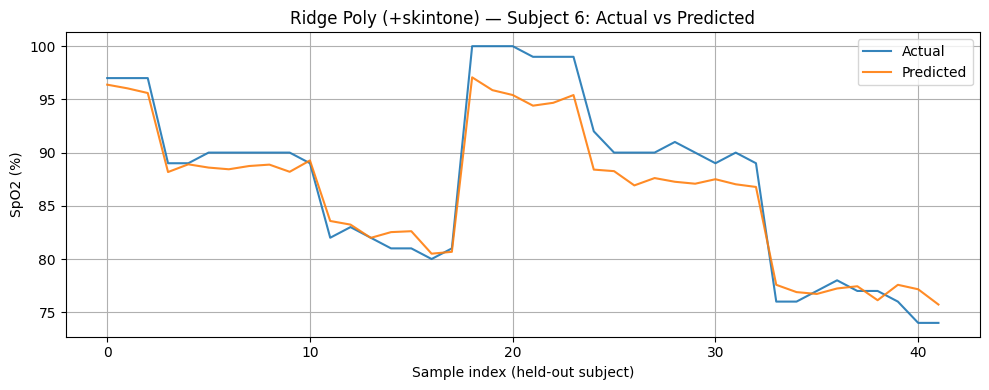

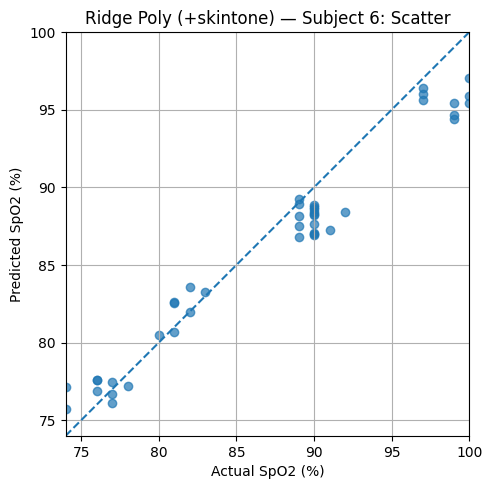

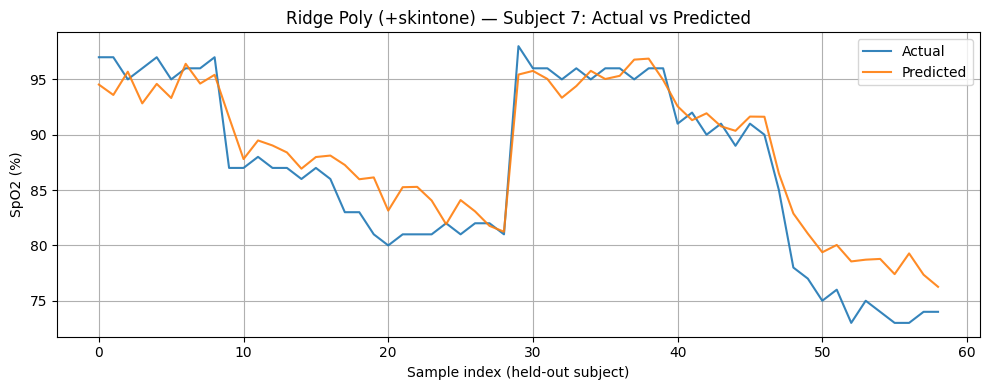

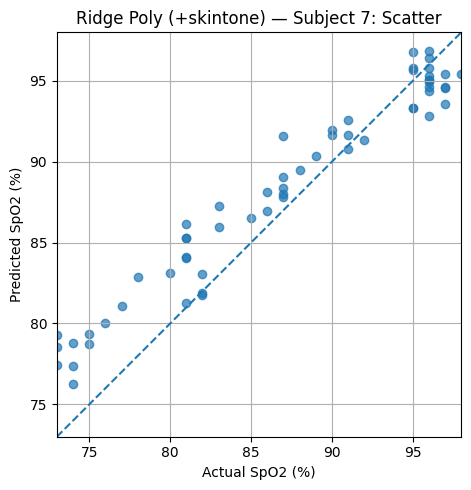

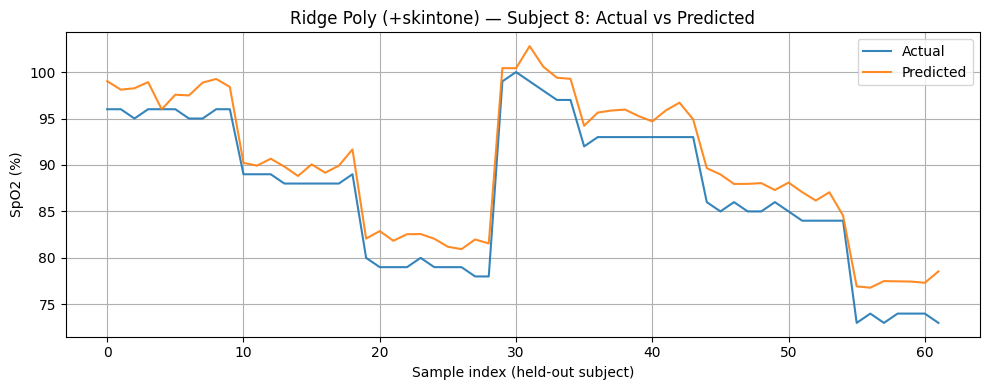

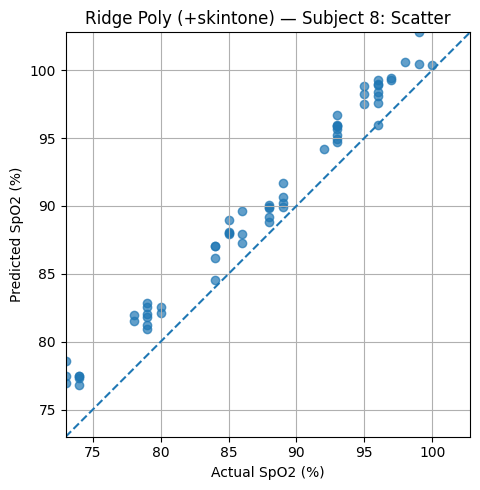

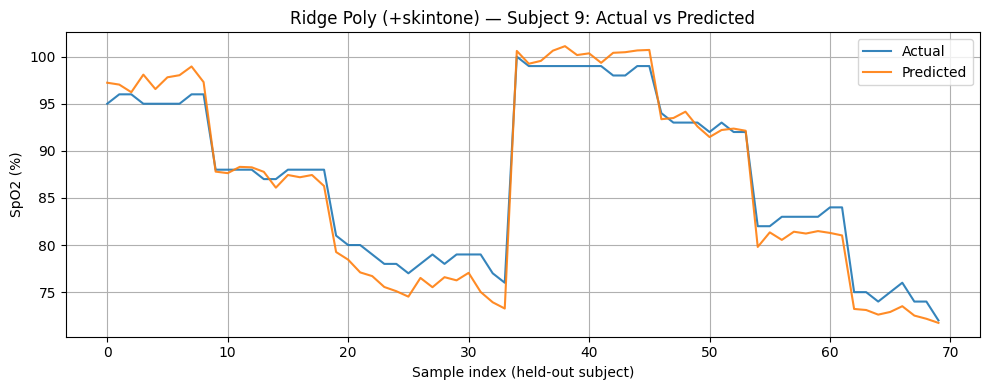

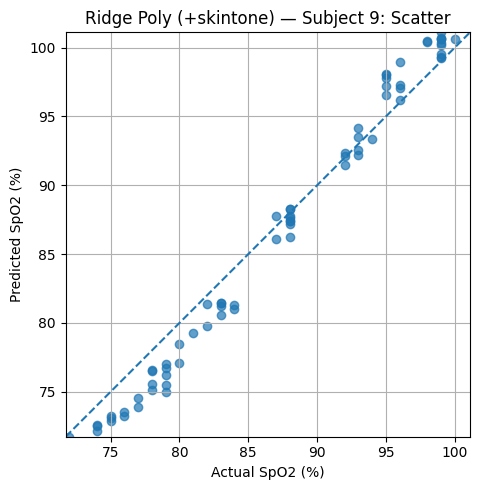

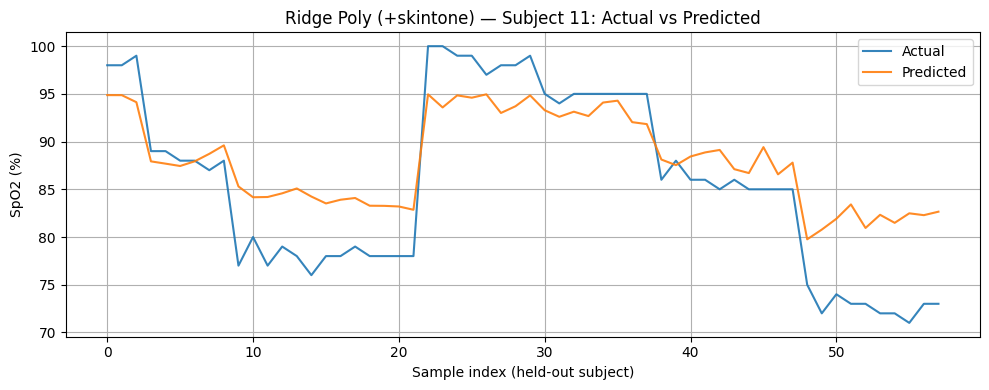

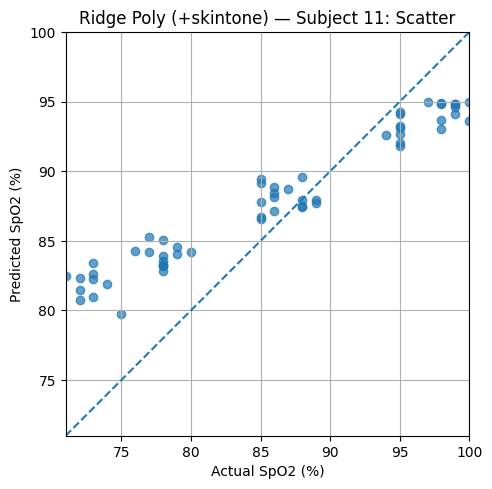

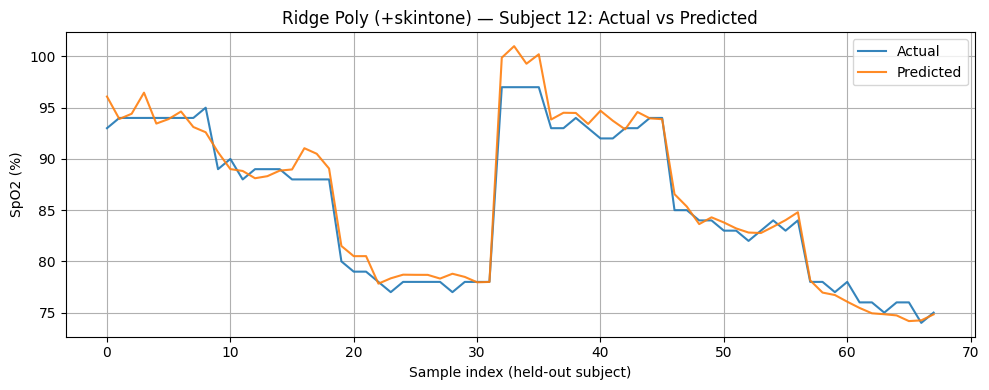

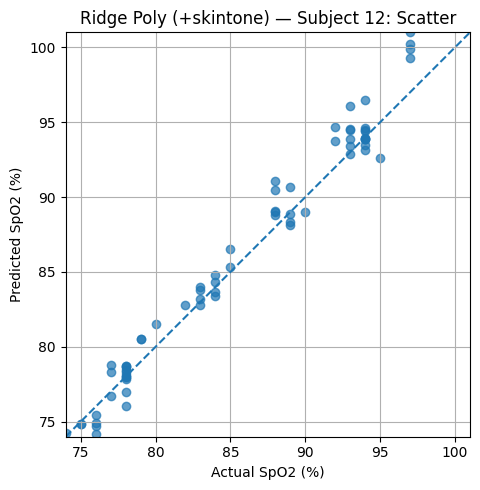

In [14]:
def ridge_poly_fit_predict(Xtr, ytr, Xte, include_tone: bool):
    # 0=r_value; 1=skintone (if present)
    r_tr = Xtr[:, 0:1]
    r_te = Xte[:, 0:1]
    poly = PolynomialFeatures(degree=3, include_bias=False)
    R_tr = poly.fit_transform(r_tr)
    R_te = poly.transform(r_te)

    if include_tone and Xtr.shape[1] > 1:
        R_tr = np.hstack([R_tr, Xtr[:, 1:2]])
        R_te = np.hstack([R_te, Xte[:, 1:2]])

    model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    model.fit(R_tr, ytr)
    return model.predict(R_te)

# r only
metrics_ridge_no, preds_ridge_no = loso_eval_per_subject(X_no_tone, y, groups,
    lambda a,b,c: ridge_poly_fit_predict(a,b,c, include_tone=False))
display(metrics_ridge_no)
plot_per_subject_bars(metrics_ridge_no, title_prefix="Ridge Poly (r only)")
plot_per_subject_predictions(preds_ridge_no, title_prefix="Ridge Poly (r only)", scatter_also=True)

# + skintone
metrics_ridge_with, preds_ridge_with = loso_eval_per_subject(X_with_tone, y, groups,
    lambda a,b,c: ridge_poly_fit_predict(a,b,c, include_tone=True))
display(metrics_ridge_with)
plot_per_subject_bars(metrics_ridge_with, title_prefix="Ridge Poly (+skintone)")
plot_per_subject_predictions(preds_ridge_with, title_prefix="Ridge Poly (+skintone)", scatter_also=True)


In [15]:
def add_model_tag(df_metrics: pd.DataFrame, tag: str):
    out = df_metrics.copy()
    out["Model"] = tag
    return out

combo = pd.concat([
    add_model_tag(metrics_quad,        "Baseline Quad (r)"),
    add_model_tag(metrics_gbr_no,      "GBR (r)"),
    add_model_tag(metrics_gbr_with,    "GBR (+tone)"),
    add_model_tag(metrics_rf_no,       "RF (r)"),
    add_model_tag(metrics_rf_with,     "RF (+tone)"),
    add_model_tag(metrics_ridge_no,    "RidgePoly (r)"),
    add_model_tag(metrics_ridge_with,  "RidgePoly (+tone)"),
], ignore_index=True)

# One row per (Subject, Model)
combo.sort_values(["SubjectNum","Model"]).reset_index(drop=True)


SubjectNum       MAE      RMSE         r  n_test              Model
0            1  4.871405  5.930773  0.885513      37  Baseline Quad (r)
1            1  5.716899  6.536851  0.887468      37        GBR (+tone)
2            1  5.184985  6.241199  0.857521      37            GBR (r)
3            1  5.279056  6.050750  0.898490      37         RF (+tone)
4            1  4.997892  6.062939  0.858433      37             RF (r)
..         ...       ...       ...       ...     ...                ...
72          12  1.841674  2.106973  0.979013      68            GBR (r)
73          12  2.749434  3.200181  0.948307      68         RF (+tone)
74          12  2.121098  2.463267  0.969172      68             RF (r)
75          12  1.056476  1.402400  0.987922      68  RidgePoly (+tone)
76          12  1.209358  1.547130  0.987874      68      RidgePoly (r)

[77 rows x 6 columns]